#### By: Peyman Shahidi
#### Created: Oct 21, 2025
#### Last Edit: Oct 22, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots/taskSequence_vs_anthropicIndex"

In [3]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [5]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,gpt4_exposure,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E2,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E2,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2


In [6]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


In [7]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]
anthropic_exposure

,task_name,automation,augmentation,label
0,act as advisers to student organizations.,0.38,0.36,Automation
1,act as an intermediary in negotiations between...,0.39,0.43,Augmentation
2,act as an intermediary in negotiations between...,0.39,0.38,Automation
3,act as liaisons between on-site managers or te...,0.56,0.00,Automation
4,adapt instructional content or delivery method...,0.29,0.70,Augmentation
...,...,...,...,...
2293,"write, prepare, and deliver statements for the...",0.00,0.79,Augmentation
2294,"write, present, and publish reports that recor...",0.51,0.47,Automation
2295,"write, review, or execute plans for testing ne...",0.40,0.00,Automation
2296,"write, review, or maintain engineering documen...",0.35,0.62,Augmentation


In [8]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

merged_data.head()

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual


In [9]:
# Read task sequence data
# Go through computed_objects/tasks_sequences and read all files and merge with original ONET data
# Get list of files in the directory
task_sequence_files = [f for f in os.listdir(f'{input_data_path}/computed_objects/tasks_sequences') if f.endswith('.csv')]
task_sequence = pd.concat([pd.read_csv(f'{input_data_path}/computed_objects/tasks_sequences/{file}') for file in task_sequence_files], ignore_index=True)

print(f"Task sequence data shape: {task_sequence.shape}")
print(f"Columns in task sequence: {list(task_sequence.columns)}")

# Merge task sequence data with merged_data
merged_data = pd.merge(merged_data, task_sequence[['O*NET-SOC Code', 'Task ID', 'Task Position']], on=['O*NET-SOC Code', 'Task ID'], how='left')
merged_data = merged_data[merged_data['Task Position'].notna()].reset_index(drop=True)

# Save dataset
merged_data.to_csv(f'{output_data_path}/ONET_taskPosition_AImeasures.csv', index=False)
merged_data.head(5)

Task sequence data shape: (17926, 5)
Columns in task sequence: ['Task Position', 'Task Title', 'Task ID', 'O*NET-SOC Code', 'Occupation Title']


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label,Task Position
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation,12.00
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation,4.00
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation,3.00
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual,6.00
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual,10.00


In [10]:
# Drop the supplemental tasks
merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [11]:
# # Only keep data for high AI-exposure major groups
# high_ai_exposure_Major_Group_Code_Code_Codes = ['13-0000', '15-0000', '19-0000', '21-0000', '23-0000', '25-0000', '27-0000', '41-0000', '43-0000']
# merged_data = merged_data[merged_data['Major_Group_Code'].isin(high_ai_exposure_major_groups)].reset_index(drop=True)

In [12]:
# Check the final merged data structure and explore some sample occupations
print(f"Final merged data shape: {merged_data.shape}")
print(f"Columns: {list(merged_data.columns)}")
print(f"\nLabel distribution:")
print(merged_data['label'].value_counts())

# Find occupations with good task sequences (have multiple tasks with position data)
occupation_task_counts = merged_data.groupby(['O*NET-SOC Code', 'Occupation Title']).size().reset_index(name='task_count')
occupation_task_counts = occupation_task_counts.sort_values('task_count', ascending=False)
print(f"\nTop 10 occupations by task count:")
print(occupation_task_counts.head(10))

# Select a few example occupations for visualization
example_occupations = occupation_task_counts.head(5)['O*NET-SOC Code'].tolist()
print(f"\nSelected example occupations: {example_occupations}")

# Show sample data for first occupation
sample_occ_code = example_occupations[0]
sample_data = merged_data[merged_data['O*NET-SOC Code'] == sample_occ_code].copy()
sample_data = sample_data.sort_values('Task Position')
print(f"\nSample data for {sample_data['Occupation Title'].iloc[0]}:")
sample_data[['Task Position', 'Task Title', 'label']].head(10)

Final merged data shape: (12525, 45)
Columns: ['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type', 'Job Zone', 'Task_Time_Percentage', 'Hourly_Mean_Wage', 'Hourly_P10_Wage', 'Hourly_P25_Wage', 'Hourly_Median_Wage', 'Hourly_P75_Wage', 'Hourly_P90_Wage', 'Annual_Mean_Wage', 'Annual_P10_Wage', 'Annual_P25_Wage', 'Annual_Median_Wage', 'Annual_P75_Wage', 'Annual_P90_Wage', 'FT_Daily', 'FT_Hourly or more', 'FT_More than monthly', 'FT_More than weekly', 'FT_More than yearly', 'FT_Several times daily', 'FT_Yearly or less', 'Importance', 'Relevance', 'Base_SOC_Code', 'Major_Group_Code', 'Major_Group_Title', 'Minor_Group_Code', 'Minor_Group_Title', 'Broad_Occupation_Code', 'Broad_Occupation_Title', 'Detailed_Occupation_Code', 'Detailed_Occupation_Title', 'gpt4_exposure', 'human_labels', 'task_normalized', 'task_name', 'automation', 'augmentation', 'label', 'Task Position']

Label distribution:
label
Manual          10985
Augmentation     1136
Automation        404
Name: c

,Task Position,Task Title,label
4468,1.00,Collaborate with other teachers and administra...,Manual
4463,2.00,Prepare objectives and outlines for courses of...,Automation
4449,3.00,"Establish clear objectives for all lessons, un...",Manual
4451,4.00,Modify the general education curriculum for sp...,Manual
4450,5.00,Develop and implement strategies to meet the n...,Manual
4443,6.00,"Confer with parents, administrators, testing s...",Manual
4452,7.00,Meet with other professionals to discuss indiv...,Manual
4456,8.00,Coordinate placement of students with special ...,Manual
4458,9.00,Monitor teachers and teacher assistants to ens...,Manual
4464,10.00,Confer with other staff members to plan and sc...,Manual


## Plot Sequence of Occupation Tasks

In [13]:
# import os
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from matplotlib.patches import Rectangle
# import numpy as np


# def plot_task_sequence(data, occ_code, title_max_length=50):
#     """Plot task sequence for a specific occupation with color-coded rectangles"""

#     # Filter and sort data for the occupation
#     occ_data = data[data['O*NET-SOC Code'] == occ_code].copy()
#     occ_data = occ_data.sort_values('Task Position')

#     if len(occ_data) == 0 or occ_data['Task Position'].isna().all():
#         print(f"No data with positions found for occupation {occ_code}")
#         return None

#     # Color mapping
#     color_map = {
#         'Manual': 'lightgray',
#         'Augmentation': 'orange',
#         'Automation': 'green'
#     }

#     # Create figure
#     fig, ax = plt.subplots(figsize=(16, max(6, len(occ_data) * 0.4)))

#     # Plot rectangles for each task
#     for i, (idx, row) in enumerate(occ_data.iterrows()):
#         y_pos = len(occ_data) - i - 1  # Start from top

#         # Create rectangle
#         rect = Rectangle((0, y_pos), 10, 0.8,
#                         facecolor=color_map.get(row['label'], 'lightgray'),
#                         edgecolor='black',
#                         linewidth=1)
#         ax.add_patch(rect)

#         # Truncate task title if too long
#         task_title = str(row['Task Title'])
#         if len(task_title) > title_max_length:
#             task_title = task_title[:title_max_length] + "..."

#         # Add task position number on the left
#         ax.text(-0.5, y_pos + 0.4, f"{int(row['Task Position'])}",
#                ha='right', va='center', fontweight='bold', fontsize=10)

#         # Add task title inside rectangle
#         ax.text(0.2, y_pos + 0.4, task_title,
#                ha='left', va='center', fontsize=9, wrap=True)

#         # Add label on the right
#         ax.text(10.2, y_pos + 0.4, row['label'],
#                ha='left', va='center', fontweight='bold', fontsize=9,
#                color=color_map.get(row['label'], 'black'))

#     # Set up the plot
#     ax.set_xlim(-2, 15)
#     ax.set_ylim(-0.5, len(occ_data) - 0.1)

#     # Remove axes
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)

#     # Add title
#     occupation_title = occ_data['Occupation Title'].iloc[0]
#     plt.title(f"Task Sequence for {occupation_title}\n({occ_code})",
#              fontsize=14, fontweight='bold', pad=20)

#     # Add legend
#     legend_elements = [patches.Patch(color='lightgray', label='Manual'),
#                       patches.Patch(color='orange', label='Augmentation'),
#                       patches.Patch(color='green', label='Automation')]
#     ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

#     plt.tight_layout()
#     return fig


# # Create output subfolder for all occupation plots
# output_folder = os.path.join(output_plot_path, "all_occupation_task_sequences")
# os.makedirs(output_folder, exist_ok=True)

# # Iterate over all occupations and save plots
# occupations = merged_data['O*NET-SOC Code'].unique()
# print(f"Found {len(occupations):,} occupations to process. Plots will be saved to: {output_folder}")

# summary_rows = []
# for i, occ_code in enumerate(sorted(occupations)):
#     try:
#         occ_data = merged_data[merged_data['O*NET-SOC Code'] == occ_code].copy()
#         n_tasks = len(occ_data)
#         # Skip if no tasks or no position information
#         if n_tasks == 0 or occ_data['Task Position'].isna().all():
#             print(f"[{i+1}/{len(occupations)}] Skipping {occ_code}: no positional task data")
#             summary_rows.append({
#                 'O*NET-SOC Code': occ_code,
#                 'Occupation Title': occ_data['Occupation Title'].iloc[0] if len(occ_data) > 0 else '',
#                 'n_tasks': n_tasks,
#                 'manual': 0,
#                 'augmentation': 0,
#                 'automation': 0,
#                 'filename': '',
#                 'status': 'skipped_no_positions'
#             })
#             continue

#         occ_data = occ_data.sort_values('Task Position')

#         fig = plot_task_sequence(merged_data, occ_code)
#         if fig is None:
#             print(f"[{i+1}/{len(occupations)}] No figure produced for {occ_code}")
#             summary_rows.append({
#                 'O*NET-SOC Code': occ_code,
#                 'Occupation Title': occ_data['Occupation Title'].iloc[0],
#                 'n_tasks': n_tasks,
#                 'manual': occ_data['label'].value_counts().get('Manual', 0),
#                 'augmentation': occ_data['label'].value_counts().get('Augmentation', 0),
#                 'automation': occ_data['label'].value_counts().get('Automation', 0),
#                 'filename': '',
#                 'status': 'no_figure'
#             })
#             continue

#         # Safe filename
#         occ_title = occ_data['Occupation Title'].iloc[0]
#         safe_title = ''.join(c if (c.isalnum() or c in (' ', '_', '-')) else '_' for c in occ_title).replace(' ', '_')[:120]
#         filename = os.path.join(output_folder, f"task_sequence_{occ_code}_{safe_title}.png")

#         # Save and close
#         fig.savefig(filename, dpi=300, bbox_inches='tight')
#         plt.close(fig)

#         counts = occ_data['label'].value_counts()
#         summary_rows.append({
#             'O*NET-SOC Code': occ_code,
#             'Occupation Title': occ_title,
#             'n_tasks': n_tasks,
#             'manual': counts.get('Manual', 0),
#             'augmentation': counts.get('Augmentation', 0),
#             'automation': counts.get('Automation', 0),
#             'filename': filename,
#             'status': 'saved'
#         })

#         if (i + 1) % 50 == 0:
#             print(f"Processed {i+1}/{len(occupations)} occupations")

#     except Exception as e:
#         print(f"Error processing {occ_code}: {e}")
#         summary_rows.append({
#             'O*NET-SOC Code': occ_code,
#             'Occupation Title': occ_data['Occupation Title'].iloc[0] if 'occ_data' in locals() and len(occ_data) > 0 else '',
#             'n_tasks': len(occ_data) if 'occ_data' in locals() else 0,
#             'manual': occ_data['label'].value_counts().get('Manual', 0) if 'occ_data' in locals() else 0,
#             'augmentation': occ_data['label'].value_counts().get('Augmentation', 0) if 'occ_data' in locals() else 0,
#             'automation': occ_data['label'].value_counts().get('Automation', 0) if 'occ_data' in locals() else 0,
#             'filename': '',
#             'status': 'error',
#             'error_msg': str(e)
#         })

# # # Save summary CSV
# # summary_df = pd.DataFrame(summary_rows)
# # summary_csv_path = os.path.join(output_folder, 'task_sequence_summary.csv')
# # summary_df.to_csv(summary_csv_path, index=False)
# # print(f"Saved summary CSV with {len(summary_df)} rows to: {summary_csv_path}")
# # print("Done. Open the notebook and run this cell (or execute the notebook) to generate the plots.")


## Calculate some measures of fragmentation: 
1) What fraction of automated tasks are followed by an augmented task?
2) What fraction of automated tasks have an augmented task either before or after them (must be weakly higher than previous measure)?
3) What's the distribution of length of AI chains (augmented or automated)?
4) What's the number of switches from Manual to AI(augmented or automated) tasks?
5) Fragmentation Index as defined in the paper: +1 for every Manual task and +1 for every run of AI (augmented or automated) task

In [14]:
# Compute fragmentation measures by occupation
import os
from collections import Counter, defaultdict

# We'll operate on the 'merged_data' DataFrame which already contains:
# - 'O*NET-SOC Code' (occupation code)
# - 'Task ID'
# - 'Task Position' (numeric position within the occupation)
# - 'label' with values 'Automation', 'Augmentation', or 'Manual'

# Ensure Task Position is numeric and drop rows missing it (should already be filtered above)
merged_data['Task Position'] = pd.to_numeric(merged_data['Task Position'], errors='coerce')
data_with_pos = merged_data[merged_data['Task Position'].notna()].copy()

# Group by occupation and compute measures
results = []
ai_chain_lengths = defaultdict(list)  # occ_code -> list of chain lengths

for occ_code, occ_df in data_with_pos.groupby('O*NET-SOC Code'):
    occ_df = occ_df.sort_values('Task Position').reset_index(drop=True)
    labels = occ_df['label'].tolist()

    # Positions of automation and augmentation tasks
    is_auto = [1 if l == 'Automation' else 0 for l in labels]
    is_aug = [1 if l == 'Augmentation' else 0 for l in labels]

    # counts
    n_automation = sum(is_auto)
    n_augmentation = sum(is_aug)
    n_ai = n_automation + n_augmentation

    # 1) Fraction of automated tasks followed by an augmented task
    auto_indices = [i for i, v in enumerate(is_auto) if v == 1]
    if len(auto_indices) == 0:
        frac_followed = None
    else:
        followed_count = 0
        for i in auto_indices:
            if i + 1 < len(labels) and labels[i+1] == 'Augmentation':
                followed_count += 1
        frac_followed = followed_count / len(auto_indices)

    # 2) Fraction of automated tasks that have augmented before OR after (weakly higher)
    if len(auto_indices) == 0:
        frac_adjacent = None
    else:
        adjacent_count = 0
        for i in auto_indices:
            has_before = (i - 1 >= 0 and labels[i-1] == 'Augmentation')
            has_after = (i + 1 < len(labels) and labels[i+1] == 'Augmentation')
            if has_before or has_after:
                adjacent_count += 1
        frac_adjacent = adjacent_count / len(auto_indices)

    # 3) Distribution of AI chain lengths: each consecutive run of Automation or Augmentation
    #    counts as a single chain. For example, ...Manual, A, A, Aug, Manual... -> one chain of length 3.
    chains = []
    current_len = 0
    for l in labels:
        if l in ('Automation', 'Augmentation'):
            current_len += 1
        else:
            if current_len > 0:
                chains.append(current_len)  # append the run length once
                current_len = 0
    if current_len > 0:
        chains.append(current_len)

    # store chain lengths for occupation
    ai_chain_lengths[occ_code].extend(chains)

    # count manual tasks
    n_manual = sum(1 for l in labels if l == 'Manual')

    # 4) Number of switches: Manual -> AI and AI -> Manual (immediate transitions)
    manual_to_ai_switches = 0
    ai_to_manual_switches = 0
    for i in range(len(labels) - 1):
        cur, nxt = labels[i], labels[i+1]
        if cur == 'Manual' and nxt in ('Automation', 'Augmentation'):
            manual_to_ai_switches += 1
        if cur in ('Automation', 'Augmentation') and nxt == 'Manual':
            ai_to_manual_switches += 1
    manual_ai_switches_total = manual_to_ai_switches + ai_to_manual_switches

    # Fragmentation index: +1 per manual task, +1 per run of consecutive AI tasks
    ai_chain_count = len(chains)
    fragmentation_index = n_manual + ai_chain_count
    fragmentation_index_per_task = fragmentation_index / len(labels) if len(labels) > 0 else float('nan')

    results.append({
        'O*NET-SOC Code': occ_code,
        'Occupation Title': occ_df['Occupation Title'].iloc[0] if 'Occupation Title' in occ_df.columns else '',
        'n_tasks': len(labels),
        'n_ai': n_ai,
        'n_automation': n_automation,
        'n_augmentation': n_augmentation,
        'n_manual': n_manual,
        'frac_auto_followed_by_aug': frac_followed,
        'frac_auto_adjacent_aug': frac_adjacent,
        'ai_chain_count': ai_chain_count,
        'ai_chain_mean_length': np.mean(chains) if len(chains) > 0 else 0,
        'manual_to_ai_switches': manual_to_ai_switches,
        'ai_to_manual_switches': ai_to_manual_switches,
        'manual_ai_switches_total': manual_ai_switches_total,
        'fragmentation_index': fragmentation_index,
        'fragmentation_index_per_task': fragmentation_index_per_task,
    })

# Create summary DataFrame
frag_df = pd.DataFrame(results)

# Flatten chain length distribution into a single DataFrame for analysis/plotting
chain_rows = []
for occ, lengths in ai_chain_lengths.items():
    for L in lengths:
        chain_rows.append({'O*NET-SOC Code': occ, 'chain_length': L})

chain_df = pd.DataFrame(chain_rows)

# Save results to computed_objects for later use
os.makedirs(f'{input_data_path}/computed_objects/fragmentation_measures', exist_ok=True)
frag_df.to_csv(f'{input_data_path}/computed_objects/fragmentation_measures/occupation_fragmentation_summary.csv', index=False)
chain_df.to_csv(f'{input_data_path}/computed_objects/fragmentation_measures/chain_length_distribution.csv', index=False)

print(f'Saved occupation fragmentation summary to: {input_data_path}/computed_objects/fragmentation_measures/occupation_fragmentation_summary.csv')
print(f'Saved chain length distribution to: {input_data_path}/computed_objects/fragmentation_measures/chain_length_distribution.csv')

# Show top occupations by number of AI chains and example statistics
print('Top occupations by AI chain count:')
display(frag_df.sort_values('ai_chain_count', ascending=False).head(10))

# Basic distribution summary of chain lengths across all occupations
if len(chain_df) > 0:
    print('Chain length distribution (counts):')
    display(chain_df['chain_length'].value_counts().sort_index())
else:
    print('No AI chains found in the dataset')


Saved occupation fragmentation summary to: ../data/computed_objects/fragmentation_measures/occupation_fragmentation_summary.csv
Saved chain length distribution to: ../data/computed_objects/fragmentation_measures/chain_length_distribution.csv
Top occupations by AI chain count:


,O*NET-SOC Code,Occupation Title,n_tasks,n_ai,n_automation,n_augmentation,n_manual,frac_auto_followed_by_aug,frac_auto_adjacent_aug,ai_chain_count,ai_chain_mean_length,manual_to_ai_switches,ai_to_manual_switches,manual_ai_switches_total,fragmentation_index,fragmentation_index_per_task
257,25-2021.00,"Elementary School Teachers, Except Special Edu...",36,12,9,3,24,0.11,0.11,9,1.33,8,9,17,33,0.92
263,25-2057.00,"Special Education Teachers, Middle School",37,11,8,3,26,0.00,0.00,9,1.22,8,9,17,35,0.95
259,25-2023.00,"Career/Technical Education Teachers, Middle Sc...",31,12,9,3,19,0.00,0.00,9,1.33,8,9,17,28,0.90
261,25-2032.00,"Career/Technical Education Teachers, Secondary...",33,11,8,3,22,0.00,0.00,8,1.38,7,8,15,30,0.91
260,25-2031.00,"Secondary School Teachers, Except Special and ...",31,13,9,4,18,0.00,0.00,8,1.62,7,8,15,26,0.84
258,25-2022.00,"Middle School Teachers, Except Special and Car...",34,13,9,4,21,0.11,0.11,7,1.86,6,7,13,28,0.82
522,43-4031.00,"Court, Municipal, and License Clerks",25,8,2,6,17,0.00,0.00,7,1.14,6,7,13,24,0.96
255,25-2011.00,"Preschool Teachers, Except Special Education",32,7,4,3,25,0.00,0.00,7,1.00,6,6,12,32,1.00
266,25-3011.00,"Adult Basic Education, Adult Secondary Educati...",29,10,5,5,19,0.20,0.20,7,1.43,7,6,13,26,0.90
112,15-1299.08,Computer Systems Engineers/Architects,28,12,1,11,16,0.00,0.00,7,1.71,7,7,14,23,0.82


Chain length distribution (counts):


chain_length
1     858
2     179
3      52
4      27
5       4
6       2
8       1
9       1
11      1
Name: count, dtype: int64

In [15]:
# Compute aggregated summaries (weighted by number of Automation tasks) for SOC levels and overall
import os

# Load the adjacency CSVs if available, else use in-memory dfs
base_dir = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures')
major_path = os.path.join(base_dir, 'adjacency_by_soc_major.csv')
minor_path = os.path.join(base_dir, 'adjacency_by_soc_minor.csv')
detailed_path = os.path.join(base_dir, 'adjacency_by_soc_detailed.csv')

major_df = pd.read_csv(major_path) if os.path.exists(major_path) else globals().get('major_df', pd.DataFrame())
minor_df = pd.read_csv(minor_path) if os.path.exists(minor_path) else globals().get('minor_df', pd.DataFrame())
detailed_df = pd.read_csv(detailed_path) if os.path.exists(detailed_path) else globals().get('detailed_df', pd.DataFrame())

# Helper: compute weighted fraction for a df (weight by n_auto)
def weighted_stats(df):
    df2 = df.copy()
    df2['n_auto'] = pd.to_numeric(df2.get('n_auto', 0), errors='coerce').fillna(0).astype(int)
    df2 = df2[df2['n_auto'] > 0].copy()
    if df2.empty:
        return {'weighted_frac_followed': float('nan'), 'weighted_frac_adjacent': float('nan'), 'total_n_auto': 0}
    # Convert fractions to numeric
    df2['frac_followed'] = pd.to_numeric(df2.get('frac_followed', 0), errors='coerce')
    df2['frac_adjacent'] = pd.to_numeric(df2.get('frac_adjacent', 0), errors='coerce')
    total_n_auto = df2['n_auto'].sum()
    w_followed = (df2['frac_followed'] * df2['n_auto']).sum() / total_n_auto if total_n_auto > 0 else float('nan')
    w_adjacent = (df2['frac_adjacent'] * df2['n_auto']).sum() / total_n_auto if total_n_auto > 0 else float('nan')
    return {'weighted_frac_followed': w_followed, 'weighted_frac_adjacent': w_adjacent, 'total_n_auto': int(total_n_auto)}

summary_rows = []
for lvl, df_lvl in [('major', major_df), ('minor', minor_df), ('detailed', detailed_df)]:
    if df_lvl is None or len(df_lvl) == 0:
        stats = {'weighted_frac_followed': float('nan'), 'weighted_frac_adjacent': float('nan'), 'total_n_auto': 0}
        n_groups_nonzero = 0
    else:
        # ensure numeric and drop groups with no automation tasks
        df_lvl = df_lvl.copy()
        df_lvl['n_auto'] = pd.to_numeric(df_lvl.get('n_auto', 0), errors='coerce').fillna(0).astype(int)
        df_lvl_nonzero = df_lvl[df_lvl['n_auto'] > 0].copy()
        n_groups_nonzero = len(df_lvl_nonzero)
        stats = weighted_stats(df_lvl_nonzero)
    row = {
        'level': lvl,
        'weighted_frac_followed': stats['weighted_frac_followed'],
        'weighted_frac_adjacent': stats['weighted_frac_adjacent'],
        'total_n_auto': stats['total_n_auto'],
        'n_groups': n_groups_nonzero
    }
    summary_rows.append(row)

# Overall (use detailed_df as the atomic units if available, else aggregate from merged data)
if 'detailed_df' in globals() and len(detailed_df) > 0:
    # filter out any rows with n_auto == 0 before computing overall stats
    detailed_df2 = detailed_df.copy()
    detailed_df2['n_auto'] = pd.to_numeric(detailed_df2.get('n_auto', 0), errors='coerce').fillna(0).astype(int)
    detailed_df2 = detailed_df2[detailed_df2['n_auto'] > 0].copy()
    overall_stats = weighted_stats(detailed_df2)
else:
    # fallback: compute from data_with_pos by treating entire dataset as one group
    tmp = data_with_pos.copy()
    tmp = tmp.sort_values(['O*NET-SOC Code', 'Task Position'])
    # compute counts across occupations: total automation tasks, of which how many followed/adjacent
    labels = tmp['label'].fillna('Manual').astype(str).tolist()
    n_auto = 0
    followed = 0
    adjacent = 0
    for occ, occ_df in tmp.groupby('O*NET-SOC Code'):
        occ_df = occ_df.sort_values('Task Position')
        labs = occ_df['label'].fillna('Manual').astype(str).tolist()
        for i, lab in enumerate(labs):
            if lab == 'Automation':
                n_auto += 1
                if i + 1 < len(labs) and labs[i+1] == 'Augmentation':
                    followed += 1
                if (i - 1 >= 0 and labs[i-1] == 'Augmentation') or (i + 1 < len(labs) and labs[i+1] == 'Augmentation'):
                    adjacent += 1
    overall_stats = {'weighted_frac_followed': (followed / n_auto) if n_auto>0 else float('nan'), 'weighted_frac_adjacent': (adjacent / n_auto) if n_auto>0 else float('nan'), 'total_n_auto': int(n_auto)}

summary_rows.append({'level': 'overall', 'weighted_frac_followed': overall_stats['weighted_frac_followed'], 'weighted_frac_adjacent': overall_stats['weighted_frac_adjacent'], 'total_n_auto': overall_stats['total_n_auto'], 'n_groups': 1})

summary_df = pd.DataFrame(summary_rows)
out_summary = os.path.join(base_dir, 'adjacency_summary_weighted.csv')
summary_df.to_csv(out_summary, index=False)
print(f'Saved weighted summary to: {out_summary}')
display(summary_df)

# Print readable percentages
for _, r in summary_df.iterrows():
    wf = r['weighted_frac_followed']
    wa = r['weighted_frac_adjacent']
    print(f"{r['level']}: frac_followed = {wf:.3%} (n_auto={int(r['total_n_auto'])}), frac_adjacent = {wa:.3%}")

# Done
summary_df

Saved weighted summary to: ../data/computed_objects/fragmentation_measures/adjacency_summary_weighted.csv


,level,weighted_frac_followed,weighted_frac_adjacent,total_n_auto,n_groups
0,major,0.10,0.18,404,20
1,minor,0.12,0.22,404,63
2,detailed,0.16,0.27,404,224
3,overall,0.16,0.27,404,1


major: frac_followed = 10.149% (n_auto=404), frac_adjacent = 18.069%
minor: frac_followed = 11.881% (n_auto=404), frac_adjacent = 21.782%
detailed: frac_followed = 16.337% (n_auto=404), frac_adjacent = 27.475%
overall: frac_followed = 16.337% (n_auto=404), frac_adjacent = 27.475%


,level,weighted_frac_followed,weighted_frac_adjacent,total_n_auto,n_groups
0,major,0.10,0.18,404,20
1,minor,0.12,0.22,404,63
2,detailed,0.16,0.27,404,224
3,overall,0.16,0.27,404,1


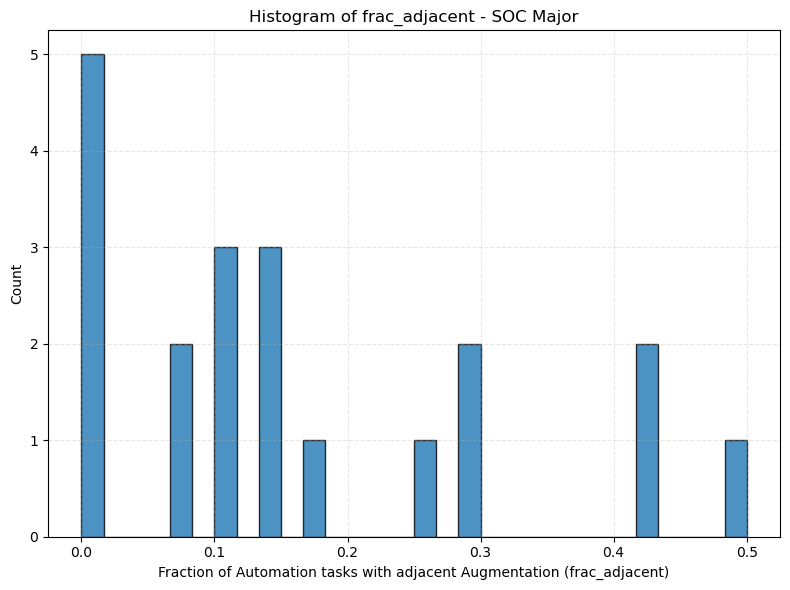

Saved histogram to: ../writeup/plots/taskSequence_vs_anthropicIndex/fragmentation/adjacency_histograms/hist_frac_adjacent_soc_major.png


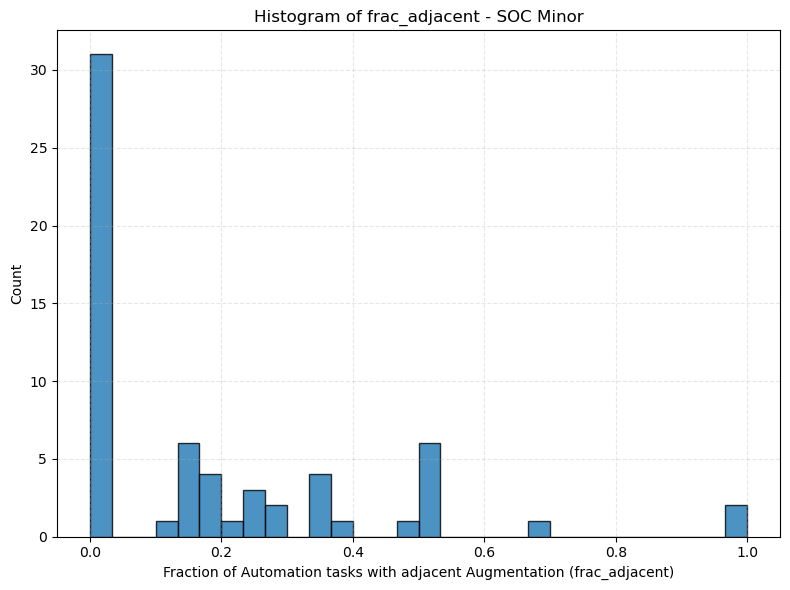

Saved histogram to: ../writeup/plots/taskSequence_vs_anthropicIndex/fragmentation/adjacency_histograms/hist_frac_adjacent_soc_minor.png


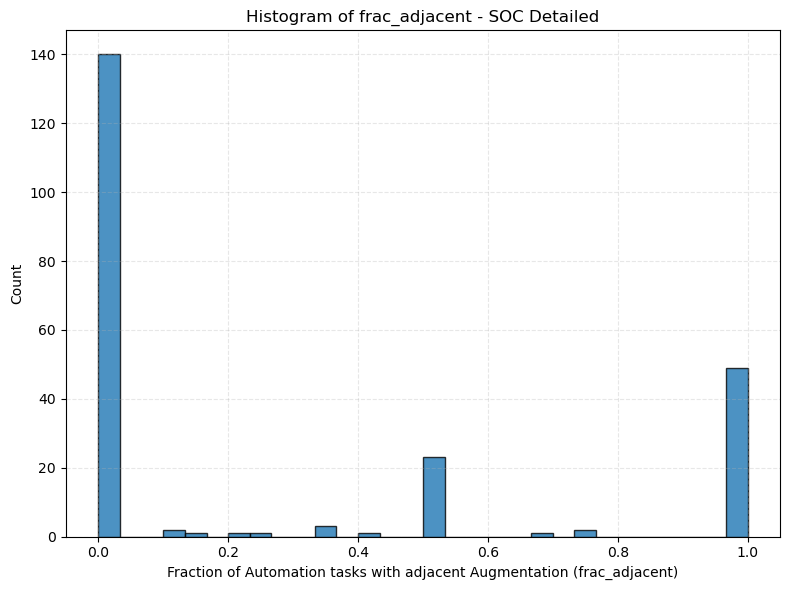

Saved histogram to: ../writeup/plots/taskSequence_vs_anthropicIndex/fragmentation/adjacency_histograms/hist_frac_adjacent_soc_detailed.png
All histograms done.


In [16]:
# Plot histograms of frac_adjacent for SOC major/minor/detailed
import os
import matplotlib.pyplot as plt

plot_out = os.path.join(output_plot_path, 'fragmentation', 'adjacency_histograms')
os.makedirs(plot_out, exist_ok=True)

# Try loading saved CSVs; if not present, use in-memory DataFrames created earlier
major_path = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'adjacency_by_soc_major.csv')
minor_path = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'adjacency_by_soc_minor.csv')
detailed_path = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'adjacency_by_soc_detailed.csv')

if os.path.exists(major_path):
    major_df = pd.read_csv(major_path)
else:
    major_df = globals().get('major_df', pd.DataFrame())
if os.path.exists(minor_path):
    minor_df = pd.read_csv(minor_path)
else:
    minor_df = globals().get('minor_df', pd.DataFrame())
if os.path.exists(detailed_path):
    detailed_df = pd.read_csv(detailed_path)
else:
    detailed_df = globals().get('detailed_df', pd.DataFrame())

def plot_hist(df, soc_label, fname):
    if df is None or len(df) == 0:
        print(f'No data for {soc_label}, skipping')
        return
    # drop rows with missing frac_adjacent (n_auto == 0)
    df2 = df.loc[pd.to_numeric(df['frac_adjacent'], errors='coerce').notna()].copy()
    if df2.empty:
        print(f'No non-missing frac_adjacent for {soc_label}, skipping')
        return
    values = df2['frac_adjacent'].astype(float)
    plt.figure(figsize=(8,6))
    plt.hist(values, bins=30, color='C0', edgecolor='k', alpha=0.8)
    plt.xlabel('Fraction of Automation tasks with adjacent Augmentation (frac_adjacent)')
    plt.ylabel('Count')
    plt.title(f'Histogram of frac_adjacent - {soc_label}')
    plt.grid(True, linestyle='--', alpha=0.3)
    out = os.path.join(plot_out, fname)
    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.show()
    print(f'Saved histogram to: {out}')

# Plot for each level
plot_hist(major_df, 'SOC Major', 'hist_frac_adjacent_soc_major.png')
plot_hist(minor_df, 'SOC Minor', 'hist_frac_adjacent_soc_minor.png')
plot_hist(detailed_df, 'SOC Detailed', 'hist_frac_adjacent_soc_detailed.png')

# Done
print('All histograms done.')

In [17]:
# Compute Automation-Augmentation adjacency measures grouped by SOC levels (major, minor, detailed)
import os

# Ensure data_with_pos exists
if 'data_with_pos' not in globals():
    raise RuntimeError('data_with_pos not found. Run the earlier cells to create it.')

df = data_with_pos.copy()
df['Task Position'] = pd.to_numeric(df['Task Position'], errors='coerce')
df = df.dropna(subset=['Task Position']).copy()
df = df.sort_values(['O*NET-SOC Code', 'Task Position']).reset_index(drop=True)

# Build SOC aggregation columns: major (2 digits), minor (5 digits), detailed (full code)
df['soc_major'] = df['O*NET-SOC Code'].astype(str).str[:2] + '-0000'
df['soc_minor'] = df['O*NET-SOC Code'].astype(str).str[:5] + '-000'
df['soc_detailed'] = df['O*NET-SOC Code'].astype(str)

def compute_group_measures(group_df):
    # group_df should already be sorted by Task Position
    labels = group_df['label'].fillna('Manual').astype(str).tolist()
    auto_indices = [i for i, lab in enumerate(labels) if lab == 'Automation']
    n_auto = len(auto_indices)
    followed = 0
    adjacent = 0
    for i in auto_indices:
        # followed (i+1) within the group: count only when the next task is Augmentation
        if i + 1 < len(labels) and labels[i+1] == 'Augmentation':
            followed += 1
        # before or after: check only for Augmentation neighbors
        has_before = (i - 1 >= 0 and labels[i-1] == 'Augmentation')
        has_after = (i + 1 < len(labels) and labels[i+1] == 'Augmentation')
        if has_before or has_after:
            adjacent += 1
    frac_followed = (followed / n_auto) if n_auto > 0 else float('nan')
    frac_adjacent = (adjacent / n_auto) if n_auto > 0 else float('nan')
    return {'n_auto': n_auto, 'n_followed': followed, 'n_adjacent': adjacent,
            'frac_followed': frac_followed, 'frac_adjacent': frac_adjacent}

out_dir = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures')
os.makedirs(out_dir, exist_ok=True)

# Helper to compute for a given soc column and save CSV
def compute_and_save(soc_col, filename):
    rows = []
    for key, g in df.groupby(soc_col):
        g = g.sort_values('Task Position')
        measures = compute_group_measures(g)
        row = {soc_col: key}
        row.update(measures)
        # optionally include n_tasks and n_ai counts
        row['n_tasks'] = len(g)
        row['n_ai'] = g['label'].isin(['Automation','Augmentation']).sum()
        rows.append(row)
    out_df = pd.DataFrame(rows)
    out_path = os.path.join(out_dir, filename)
    out_df.to_csv(out_path, index=False)
    print(f'Saved {soc_col} summary to: {out_path} (rows: {len(out_df)})')
    return out_df

# Run for major, minor, and detailed levels
major_df = compute_and_save('soc_major', 'adjacency_by_soc_major.csv')
minor_df = compute_and_save('soc_minor', 'adjacency_by_soc_minor.csv')
detailed_df = compute_and_save('soc_detailed', 'adjacency_by_soc_detailed.csv')

# Print top rows for quick inspection
print('Top major groups (sample):')
display(major_df.sort_values('n_tasks', ascending=False).head(10))
print('Top minor groups (sample):')
display(minor_df.sort_values('n_tasks', ascending=False).head(10))
print('Top detailed occupations (sample):')
display(detailed_df.sort_values('n_tasks', ascending=False).head(10))

# Return the three dataframes for further programmatic use
major_df, minor_df, detailed_df

Saved soc_major summary to: ../data/computed_objects/fragmentation_measures/adjacency_by_soc_major.csv (rows: 22)
Saved soc_minor summary to: ../data/computed_objects/fragmentation_measures/adjacency_by_soc_minor.csv (rows: 108)
Saved soc_detailed summary to: ../data/computed_objects/fragmentation_measures/adjacency_by_soc_detailed.csv (rows: 836)
Top major groups (sample):


,soc_major,n_auto,n_followed,n_adjacent,frac_followed,frac_adjacent,n_tasks,n_ai
9,29-0000,14,0,1,0.00,0.07,1332,151
20,51-0000,10,0,0,0.00,0.00,1311,20
3,17-0000,26,2,2,0.08,0.08,903,106
4,19-0000,35,3,6,0.09,0.17,869,186
18,47-0000,0,0,0,NaN,NaN,858,11
0,11-0000,19,0,2,0.00,0.11,843,105
19,49-0000,3,0,0,0.00,0.00,769,30
1,13-0000,38,5,11,0.13,0.29,674,137
16,43-0000,35,2,5,0.06,0.14,626,100
21,53-0000,2,0,0,0.00,0.00,563,15


Top minor groups (sample):


,soc_minor,n_auto,n_followed,n_adjacent,frac_followed,frac_adjacent,n_tasks,n_ai
33,29-11-000,3,0,0,0.00,0.00,426,54
9,15-12-000,27,8,13,0.30,0.48,420,157
13,17-21-000,11,1,2,0.09,0.18,391,48
24,25-20-000,73,3,8,0.04,0.11,362,102
35,29-20-000,5,0,0,0.00,0.00,355,22
88,49-90-000,1,0,0,0.00,0.00,347,8
34,29-12-000,3,0,0,0.00,0.00,328,53
5,11-91-000,6,1,2,0.17,0.33,321,35
6,13-10-000,13,1,2,0.08,0.15,302,41
87,49-30-000,0,0,0,NaN,NaN,246,5


Top detailed occupations (sample):


,soc_detailed,n_auto,n_followed,n_adjacent,frac_followed,frac_adjacent,n_tasks,n_ai
264,25-2058.00,7,0,1,0.00,0.14,38,10
263,25-2057.00,8,0,0,0.00,0.00,37,11
256,25-2012.00,4,0,0,0.00,0.00,36,6
257,25-2021.00,9,1,1,0.11,0.11,36,12
392,29-9099.01,0,0,0,NaN,NaN,34,2
258,25-2022.00,9,1,1,0.11,0.11,34,13
109,15-1299.01,1,0,0,0.00,0.00,34,9
262,25-2051.00,4,0,0,0.00,0.00,34,5
261,25-2032.00,8,0,0,0.00,0.00,33,11
255,25-2011.00,4,0,0,0.00,0.00,32,7


(   soc_major  n_auto  n_followed  n_adjacent  frac_followed  frac_adjacent  \
 0    11-0000      19           0           2           0.00           0.11   
 1    13-0000      38           5          11           0.13           0.29   
 2    15-0000      37          11          16           0.30           0.43   
 3    17-0000      26           2           2           0.08           0.08   
 4    19-0000      35           3           6           0.09           0.17   
 5    21-0000       7           2           3           0.29           0.43   
 6    23-0000       7           1           2           0.14           0.29   
 7    25-0000      94          10          14           0.11           0.15   
 8    27-0000      38           1           4           0.03           0.11   
 9    29-0000      14           0           1           0.00           0.07   
 10   31-0000       9           1           1           0.11           0.11   
 11   33-0000      10           0           0       

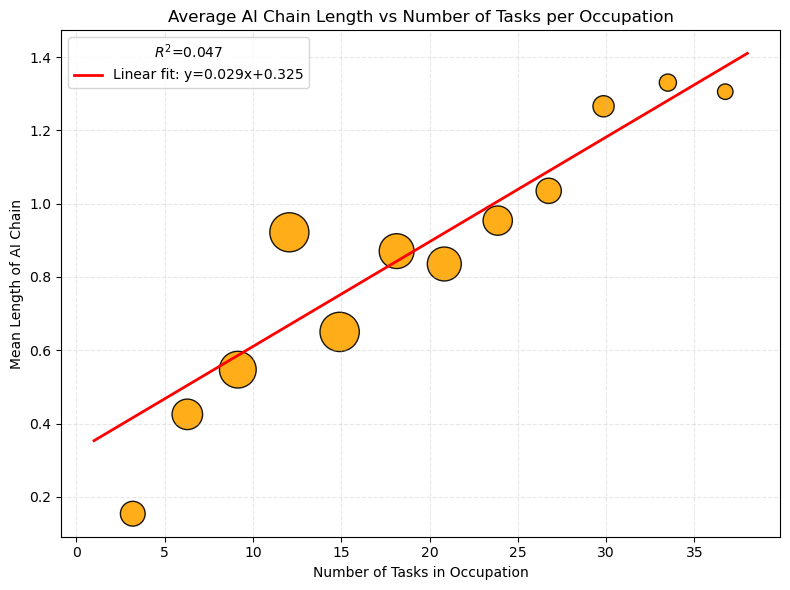

Saved binned scatter (12 bins) + regression to: ../writeup/plots/taskSequence_vs_anthropicIndex/fragmentation/tasks_aiChainMeanLength.png


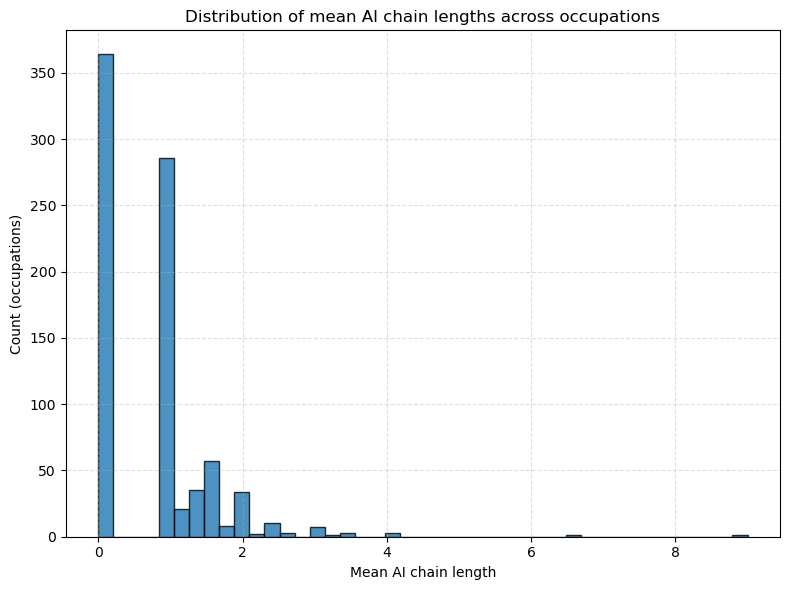

Saved histogram to: ../writeup/plots/taskSequence_vs_anthropicIndex/fragmentation/hist_aiChainMeanLength.png


In [18]:
# Binned scatter with 12 x-bins: bin centers vs mean AI chain length, point size ~ sqrt(count), alpha=0.05, plus regression
import numpy as np
import math

# Ensure frag_df exists
if 'frag_df' not in globals():
    frag_df = pd.read_csv(f'{input_data_path}/computed_objects/fragmentation_measures/occupation_fragmentation_summary.csv')

# Create output folder
plot_folder = os.path.join(output_plot_path, 'fragmentation')
os.makedirs(plot_folder, exist_ok=True)

# Prepare data (drop missing)
x_all = frag_df['n_tasks']
y_all = frag_df['ai_chain_mean_length']
mask = x_all.notna() & y_all.notna()
x = x_all[mask].astype(float)
y = y_all[mask].astype(float)

if len(x) == 0:
    print('No data available for binned scatter plot')
else:
    # Define 12 bins across x range
    n_bins = 12
    x_min, x_max = x.min(), x.max()
    if x_min == x_max:
        bins = np.linspace(x_min - 0.5, x_max + 0.5, n_bins + 1)
    else:
        bins = np.linspace(x_min, x_max, n_bins + 1)

    # Assign bins
    bin_idx = np.digitize(x, bins) - 1  # 0-based bin index; values == len(bins) go to last bin
    bin_idx[bin_idx < 0] = 0
    bin_idx[bin_idx >= n_bins] = n_bins - 1

    # Aggregate per bin: mean x, mean y, count
    bin_centers = []
    bin_means_y = []
    bin_counts = []
    for b in range(n_bins):
        sel = (bin_idx == b)
        cnt = sel.sum()
        if cnt == 0:
            # skip empty bins but keep placeholder
            bin_centers.append((bins[b] + bins[b+1]) / 2)
            bin_means_y.append(np.nan)
            bin_counts.append(0)
        else:
            bin_centers.append(x[sel].mean())
            bin_means_y.append(y[sel].mean())
            bin_counts.append(int(cnt))

    bin_centers = np.array(bin_centers)
    bin_means_y = np.array(bin_means_y)
    bin_counts = np.array(bin_counts)

    # Scale marker sizes by sqrt(counts) (normalize for plotting)
    # marker area proportional to sqrt(count)
    max_marker_area = 800  # max area size
    if bin_counts.max() > 0:
        sizes = np.sqrt(bin_counts)
        sizes = (sizes / sizes.max()) * max_marker_area
    else:
        sizes = np.full_like(bin_counts, 20, dtype=float)

    # Plot
    plt.figure(figsize=(8,6))

    # Overlay every observation as a low-opacity scatter (one marker per observation)
    # color 'steelblue' requested, alpha 0.05
    # plt.scatter(x, y, s=10, color='steelblue', alpha=0.05, edgecolors='none', label='Observations')

    # plot bin points; use alpha so bins are visible
    plt.scatter(bin_centers, bin_means_y, s=sizes, color='orange', alpha=0.9, edgecolors='k')

    # annotate counts optionally (commented out by default)
    # for i, c in enumerate(bin_counts):
    #     if c > 0:
    #         plt.text(bin_centers[i], bin_means_y[i], str(c), fontsize=8, ha='center', va='center')

    # Fit regression on raw points (x,y)
    try:
        coeffs = np.polyfit(x, y, 1)
        p = np.poly1d(coeffs)
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = p(x_line)
        plt.plot(x_line, y_line, color='red', linewidth=2, label=f'Linear fit: y={coeffs[0]:.3f}x+{coeffs[1]:.3f}')

        # R^2
        y_pred = p(x)
        ss_res = ((y - y_pred) ** 2).sum()
        ss_tot = ((y - y.mean()) ** 2).sum()
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float('nan')
        plt.legend(title=f'$R^2$={r2:.3f}')
    except Exception as e:
        print('Regression fit failed:', e)

    plt.xlabel('Number of Tasks in Occupation')
    plt.ylabel('Mean Length of AI Chain')
    plt.title('Average AI Chain Length vs Number of Tasks per Occupation')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    binned_scatter_path = os.path.join(plot_folder, 'tasks_aiChainMeanLength.png')
    plt.savefig(binned_scatter_path, dpi=300)
    plt.show()
    print(f'Saved binned scatter (12 bins) + regression to: {binned_scatter_path}')

# Also keep the histogram below (unchanged)
plt.figure(figsize=(8,6))
values = frag_df['ai_chain_mean_length'].dropna()
if len(values) > 1:
    q25, q75 = np.percentile(values, [25, 75])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(values) ** (1/3)) if iqr > 0 else (values.max() - values.min()) / 30
    if bin_width <= 0:
        bins = 30
    else:
        bins = max(10, int(math.ceil((values.max() - values.min()) / bin_width)))
else:
    bins = 10

plt.hist(values, bins=bins, color='C0', edgecolor='k', alpha=0.8)
plt.xlabel('Mean AI chain length')
plt.ylabel('Count (occupations)')
plt.title('Distribution of mean AI chain lengths across occupations')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
hist_path = os.path.join(plot_folder, 'hist_aiChainMeanLength.png')
plt.savefig(hist_path, dpi=300)
plt.show()
print(f'Saved histogram to: {hist_path}')


In [19]:
# Five regressions: A-E (no FE, major FE, major FE+interactions, minor FE, minor FE+interactions).
import os
import sys

# Ensure statsmodels available
try:
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
except Exception:
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'statsmodels'])
    import statsmodels.formula.api as smf
    import statsmodels.api as sm

# Load frag_df if needed
if 'frag_df' not in globals():
    frag_path = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'occupation_fragmentation_summary.csv')
    print('Loading frag_df from:', frag_path)
    frag_df = pd.read_csv(frag_path)

# Coerce numeric
frag_df['n_tasks'] = pd.to_numeric(frag_df['n_tasks'], errors='coerce')
frag_df['ai_chain_mean_length'] = pd.to_numeric(frag_df['ai_chain_mean_length'], errors='coerce')

# Build major and minor group variables
frag_df['major_group'] = frag_df['O*NET-SOC Code'].astype(str).str[:2] + '-0000'
frag_df['minor_group'] = frag_df['O*NET-SOC Code'].astype(str).str[:5] + '-000'

# Group small groups into 'Other' for both major and minor
min_count = 10
major_counts = frag_df['major_group'].value_counts()
large_majors = major_counts[major_counts >= min_count].index.tolist()
frag_df['major_group2'] = frag_df['major_group'].where(frag_df['major_group'].isin(large_majors), 'Other')

minor_counts = frag_df['minor_group'].value_counts()
large_minors = minor_counts[minor_counts >= min_count].index.tolist()
frag_df['minor_group2'] = frag_df['minor_group'].where(frag_df['minor_group'].isin(large_minors), 'Other')

# Regression dataframe
reg_df = frag_df.dropna(subset=['ai_chain_mean_length', 'n_tasks']).copy()
print(f'Regression dataset: {len(reg_df)} observations; unique major_group2: {reg_df["major_group2"].nunique()}')

# Output directory
base_out = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'analysis')
os.makedirs(base_out, exist_ok=True)

# Model A: no major-group fixed effects
print('\n=== Model A: no major-group fixed effects ===')
model_a = smf.ols('ai_chain_mean_length ~ n_tasks', data=reg_df).fit(cov_type='HC3')
print(model_a.summary())

# Save Model A outputs
with open(os.path.join(base_out, 'regression_A_noFE_summary.txt'), 'w') as f:
    f.write(model_a.summary().as_text())
coef_a = model_a.params.reset_index()
coef_a.columns = ['term', 'estimate']
coef_a['pvalue'] = model_a.pvalues.values
coef_a.to_csv(os.path.join(base_out, 'regression_A_noFE_coefficients.csv'), index=False)

# Model B: with major-group fixed effects (no interactions)
print('\n=== Model B: major-group fixed effects (C(major_group2)) ===')
model_b = smf.ols('ai_chain_mean_length ~ n_tasks + C(major_group2)', data=reg_df).fit(cov_type='HC3')
print(model_b.summary())
with open(os.path.join(base_out, 'regression_B_majorFE_summary.txt'), 'w') as f:
    f.write(model_b.summary().as_text())
coef_b = model_b.params.reset_index()
coef_b.columns = ['term', 'estimate']
coef_b['pvalue'] = model_b.pvalues.values
coef_b.to_csv(os.path.join(base_out, 'regression_B_majorFE_coefficients.csv'), index=False)

# # Model C: major-group fixed effects WITH interactions (allow slope to vary by major group)
# print('\n=== Model C: major-group FE + interactions (n_tasks * C(major_group2)) ===')
# model_c = smf.ols('ai_chain_mean_length ~ n_tasks * C(major_group2)', data=reg_df).fit(cov_type='HC3')
# print(model_c.summary())
# with open(os.path.join(base_out, 'regression_C_majorFE_interact_summary.txt'), 'w') as f:
#     f.write(model_c.summary().as_text())
# coef_c = model_c.params.reset_index()
# coef_c.columns = ['term', 'estimate']
# coef_c['pvalue'] = model_c.pvalues.values
# coef_c.to_csv(os.path.join(base_out, 'regression_C_majorFE_interact_coefficients.csv'), index=False)
# # Save interaction terms and compute group-specific slopes
# interaction_terms_c = [t for t in model_c.params.index if ':' in t or (t.startswith('n_tasks') and 'C(major_group2)' in t)]
# if len(interaction_terms_c) > 0:
#     inter_c = pd.DataFrame({
#         'term': interaction_terms_c,
#         'estimate': [model_c.params.get(t, float('nan')) for t in interaction_terms_c],
#         'pvalue': [model_c.pvalues.get(t, float('nan')) for t in interaction_terms_c]
#     })
#     inter_c.to_csv(os.path.join(base_out, 'regression_C_majorFE_interactions.csv'), index=False)
#     # compute per-major-group slopes: baseline n_tasks + each interaction term
#     base_slope_c = model_c.params.get('n_tasks', 0.0)
#     group_slopes = []
#     for g in sorted(reg_df['major_group2'].unique()):
#         if g == 'Other':
#             slope = base_slope_c
#         else:
#             term_name = f'n_tasks:C(major_group2)[T.{g}]'
#             slope = base_slope_c + model_c.params.get(term_name, 0.0)
#         group_slopes.append({'group': g, 'slope_n_tasks': slope})
#     pd.DataFrame(group_slopes).to_csv(os.path.join(base_out, 'regression_C_major_group_slopes.csv'), index=False)

# Model D: minor-group fixed effects (no interactions)
print('\n=== Model D: minor-group fixed effects (C(minor_group2)) ===')
model_d = smf.ols('ai_chain_mean_length ~ n_tasks + C(minor_group2)', data=reg_df).fit(cov_type='HC3')
print(model_d.summary())
with open(os.path.join(base_out, 'regression_D_minorFE_summary.txt'), 'w') as f:
    f.write(model_d.summary().as_text())
coef_d = model_d.params.reset_index()
coef_d.columns = ['term', 'estimate']
coef_d['pvalue'] = model_d.pvalues.values
coef_d.to_csv(os.path.join(base_out, 'regression_D_minorFE_coefficients.csv'), index=False)

# # Model E: minor-group fixed effects WITH interactions
# print('\n=== Model E: minor-group FE + interactions (n_tasks * C(minor_group2)) ===')
# model_e = smf.ols('ai_chain_mean_length ~ n_tasks * C(minor_group2)', data=reg_df).fit(cov_type='HC3')
# print(model_e.summary())
# with open(os.path.join(base_out, 'regression_E_minorFE_interact_summary.txt'), 'w') as f:
#     f.write(model_e.summary().as_text())
# coef_e = model_e.params.reset_index()
# coef_e.columns = ['term', 'estimate']
# coef_e['pvalue'] = model_e.pvalues.values
# coef_e.to_csv(os.path.join(base_out, 'regression_E_minorFE_interact_coefficients.csv'), index=False)
# # Save interaction terms and compute per-minor-group slopes
# interaction_terms_e = [t for t in model_e.params.index if ':' in t or (t.startswith('n_tasks') and 'C(minor_group2)' in t)]
# if len(interaction_terms_e) > 0:
#     inter_e = pd.DataFrame({
#         'term': interaction_terms_e,
#         'estimate': [model_e.params.get(t, float('nan')) for t in interaction_terms_e],
#         'pvalue': [model_e.pvalues.get(t, float('nan')) for t in interaction_terms_e]
#     })
#     inter_e.to_csv(os.path.join(base_out, 'regression_E_minorFE_interactions.csv'), index=False)
#     base_slope_e = model_e.params.get('n_tasks', 0.0)
#     group_slopes_e = []
#     for g in sorted(reg_df['minor_group2'].unique()):
#         if g == 'Other':
#             slope = base_slope_e
#         else:
#             term_name = f'n_tasks:C(minor_group2)[T.{g}]'
#             slope = base_slope_e + model_e.params.get(term_name, 0.0)
#         group_slopes_e.append({'group': g, 'slope_n_tasks': slope})
#     pd.DataFrame(group_slopes_e).to_csv(os.path.join(base_out, 'regression_E_minor_group_slopes.csv'), index=False)

print('\nSaved regression outputs (A-E) to:', base_out)


KeyboardInterrupt: 

In [ ]:
# Repeat regressions A-E but only for occupations with at least one AI task (n_ai > 0).
# This cell creates reg_df_ai and runs the same five models, saving outputs with '_onlyAI' suffix.
import os
# assume frag_df exists or load it
if 'frag_df' not in globals():
    frag_path = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'occupation_fragmentation_summary.csv')
    frag_df = pd.read_csv(frag_path)

# Build groups if not present
if 'major_group2' not in frag_df.columns:
    frag_df['major_group'] = frag_df['O*NET-SOC Code'].astype(str).str[:2] + '-0000'
    major_counts = frag_df['major_group'].value_counts()
    large_majors = major_counts[major_counts >= min_count].index.tolist()
    frag_df['major_group2'] = frag_df['major_group'].where(frag_df['major_group'].isin(large_majors), 'Other')
if 'minor_group2' not in frag_df.columns:
    frag_df['minor_group'] = frag_df['O*NET-SOC Code'].astype(str).str[:5] + '-000'
    minor_counts = frag_df['minor_group'].value_counts()
    large_minors = minor_counts[minor_counts >= min_count].index.tolist()
    frag_df['minor_group2'] = frag_df['minor_group'].where(frag_df['minor_group'].isin(large_minors), 'Other')

# Filter to occupations with at least one AI task
frag_df['n_ai'] = pd.to_numeric(frag_df.get('n_ai', 0), errors='coerce').fillna(0).astype(int)
reg_df_ai = frag_df[frag_df['n_ai'] > 0].dropna(subset=['ai_chain_mean_length', 'n_tasks']).copy()
print(f'Regression dataset (only AI occupations): {len(reg_df_ai)} observations; unique major_group2: {reg_df_ai["major_group2"].nunique()}')

base_out = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'analysis')
os.makedirs(base_out, exist_ok=True)

# Model A
print('\n=== [onlyAI] Model A: no major-group fixed effects ===')
model_a_ai = smf.ols('ai_chain_mean_length ~ n_tasks', data=reg_df_ai).fit(cov_type='HC3')
with open(os.path.join(base_out, 'regression_A_noFE_onlyAI_summary.txt'), 'w') as f:
    f.write(model_a_ai.summary().as_text())
pd.DataFrame({'term': model_a_ai.params.index, 'estimate': model_a_ai.params.values, 'pvalue': model_a_ai.pvalues.values}).to_csv(os.path.join(base_out, 'regression_A_noFE_onlyAI_coefficients.csv'), index=False)

# Model B
print('\n=== [onlyAI] Model B: major-group fixed effects ===')
model_b_ai = smf.ols('ai_chain_mean_length ~ n_tasks + C(major_group2)', data=reg_df_ai).fit(cov_type='HC3')
with open(os.path.join(base_out, 'regression_B_majorFE_onlyAI_summary.txt'), 'w') as f:
    f.write(model_b_ai.summary().as_text())
pd.DataFrame({'term': model_b_ai.params.index, 'estimate': model_b_ai.params.values, 'pvalue': model_b_ai.pvalues.values}).to_csv(os.path.join(base_out, 'regression_B_majorFE_onlyAI_coefficients.csv'), index=False)

# # Model C (interactions)
# print('\n=== [onlyAI] Model C: major-group FE + interactions ===')
# model_c_ai = smf.ols('ai_chain_mean_length ~ n_tasks * C(major_group2)', data=reg_df_ai).fit(cov_type='HC3')
# with open(os.path.join(base_out, 'regression_C_majorFE_interact_onlyAI_summary.txt'), 'w') as f:
#     f.write(model_c_ai.summary().as_text())
# pd.DataFrame({'term': model_c_ai.params.index, 'estimate': model_c_ai.params.values, 'pvalue': model_c_ai.pvalues.values}).to_csv(os.path.join(base_out, 'regression_C_majorFE_interact_onlyAI_coefficients.csv'), index=False)
# # save interactions and group slopes
# interaction_terms_c_ai = [t for t in model_c_ai.params.index if ':' in t]
# if len(interaction_terms_c_ai) > 0:
#     pd.DataFrame({'term': interaction_terms_c_ai, 'estimate': [model_c_ai.params.get(t, float('nan')) for t in interaction_terms_c_ai], 'pvalue': [model_c_ai.pvalues.get(t, float('nan')) for t in interaction_terms_c_ai]}).to_csv(os.path.join(base_out, 'regression_C_majorFE_interactions_onlyAI.csv'), index=False)
#     base_slope_c_ai = model_c_ai.params.get('n_tasks', 0.0)
#     group_slopes_ai = []
#     for g in sorted(reg_df_ai['major_group2'].unique()):
#         if g == 'Other':
#             slope = base_slope_c_ai
#         else:
#             term_name = f'n_tasks:C(major_group2)[T.{g}]'
#             slope = base_slope_c_ai + model_c_ai.params.get(term_name, 0.0)
#         group_slopes_ai.append({'group': g, 'slope_n_tasks': slope})
#     pd.DataFrame(group_slopes_ai).to_csv(os.path.join(base_out, 'regression_C_major_group_slopes_onlyAI.csv'), index=False)

# Model D (minor FE)
print('\n=== [onlyAI] Model D: minor-group fixed effects ===')
model_d_ai = smf.ols('ai_chain_mean_length ~ n_tasks + C(minor_group2)', data=reg_df_ai).fit(cov_type='HC3')
with open(os.path.join(base_out, 'regression_D_minorFE_onlyAI_summary.txt'), 'w') as f:
    f.write(model_d_ai.summary().as_text())
pd.DataFrame({'term': model_d_ai.params.index, 'estimate': model_d_ai.params.values, 'pvalue': model_d_ai.pvalues.values}).to_csv(os.path.join(base_out, 'regression_D_minorFE_onlyAI_coefficients.csv'), index=False)

# # Model E (minor interactions)
# print('\n=== [onlyAI] Model E: minor-group FE + interactions ===')
# model_e_ai = smf.ols('ai_chain_mean_length ~ n_tasks * C(minor_group2)', data=reg_df_ai).fit(cov_type='HC3')
# with open(os.path.join(base_out, 'regression_E_minorFE_interact_onlyAI_summary.txt'), 'w') as f:
#     f.write(model_e_ai.summary().as_text())
# pd.DataFrame({'term': model_e_ai.params.index, 'estimate': model_e_ai.params.values, 'pvalue': model_e_ai.pvalues.values}).to_csv(os.path.join(base_out, 'regression_E_minorFE_interact_onlyAI_coefficients.csv'), index=False)
# interaction_terms_e_ai = [t for t in model_e_ai.params.index if ':' in t]
# if len(interaction_terms_e_ai) > 0:
#     pd.DataFrame({'term': interaction_terms_e_ai, 'estimate': [model_e_ai.params.get(t, float('nan')) for t in interaction_terms_e_ai], 'pvalue': [model_e_ai.pvalues.get(t, float('nan')) for t in interaction_terms_e_ai]}).to_csv(os.path.join(base_out, 'regression_E_minorFE_interactions_onlyAI.csv'), index=False)
#     base_slope_e_ai = model_e_ai.params.get('n_tasks', 0.0)
#     group_slopes_e_ai = []
#     for g in sorted(reg_df_ai['minor_group2'].unique()):
#         if g == 'Other':
#             slope = base_slope_e_ai
#         else:
#             term_name = f'n_tasks:C(minor_group2)[T.{g}]'
#             slope = base_slope_e_ai + model_e_ai.params.get(term_name, 0.0)
#         group_slopes_e_ai.append({'group': g, 'slope_n_tasks': slope})
#     pd.DataFrame(group_slopes_e_ai).to_csv(os.path.join(base_out, 'regression_E_minor_group_slopes_onlyAI.csv'), index=False)

print('\nSaved only-AI regression outputs to:', base_out)


## Some Robustness Checks using Placebo(Reshuffled) Data:
1) Within occupation reshuffle task position and re-calculate adjacency measures (i.e., if automation is followed by or adjacent to augmented)
2) Randomly assign tasks to occupations w/o preserving occupation size across the entire dataset
3) Randomly assign tasks to occupations while respecting occupation sizes across the entire dataset

In [ ]:
# Placebo shuffle test: within each occupation, randomly shuffle Task Position and recompute adjacency measures
# This cell performs N permutations (default 1000) and saves the null distribution of frac_followed and frac_adjacent.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

# Parameters
N = 1000  # number of permutations; reduce if this is slow (e.g., 200-500)
seed = 42
out_dir = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures')
os.makedirs(out_dir, exist_ok=True)
plot_out = os.path.join(output_plot_path, 'fragmentation', 'placebo_shuffle')
os.makedirs(plot_out, exist_ok=True)

if 'data_with_pos' not in globals():
    raise RuntimeError('data_with_pos not found. Run earlier cells to produce it before running this placebo test.')

# Working copy and ensure Task Position is numeric
df_orig = data_with_pos[['O*NET-SOC Code', 'Task ID', 'Task Position', 'label']].copy()
df_orig['Task Position'] = pd.to_numeric(df_orig['Task Position'], errors='coerce')
df_orig = df_orig.dropna(subset=['Task Position']).copy()

# helper to compute overall dataset-level measures
def compute_dataset_measures(df):
    # df must have columns: 'O*NET-SOC Code', 'Task Position', 'label'
    total_n_auto = 0
    total_followed = 0
    total_adjacent = 0
    for occ, occ_df in df.groupby('O*NET-SOC Code'):
        occ_df = occ_df.sort_values('Task Position')
        labels = occ_df['label'].fillna('Manual').astype(str).tolist()
        auto_indices = [i for i, lab in enumerate(labels) if lab == 'Automation']
        n_auto = len(auto_indices)
        if n_auto == 0:
            continue
        followed = 0
        adjacent = 0
        for i in auto_indices:
            if i + 1 < len(labels) and labels[i+1] == 'Augmentation':
                followed += 1
            has_before = (i - 1 >= 0 and labels[i-1] == 'Augmentation')
            has_after = (i + 1 < len(labels) and labels[i+1] == 'Augmentation')
            if has_before or has_after:
                adjacent += 1
        total_n_auto += n_auto
        total_followed += followed
        total_adjacent += adjacent
    frac_followed = (total_followed / total_n_auto) if total_n_auto > 0 else float('nan')
    frac_adjacent = (total_adjacent / total_n_auto) if total_n_auto > 0 else float('nan')
    return {'total_n_auto': int(total_n_auto), 'frac_followed': float(frac_followed), 'frac_adjacent': float(frac_adjacent)}

# Compute observed measures on the original data
obs = compute_dataset_measures(df_orig)
print('Observed (original ordering):', obs)

# Run permutations
rng = np.random.default_rng(seed)
results = []
start = time()
for it in range(N):
    # Create a copy and shuffle positions within each occupation
    df_sh = df_orig.copy()
    # We'll assign shuffled Task Position values per occupation
    new_positions = []
    # operate groupwise
    for occ, occ_df in df_sh.groupby('O*NET-SOC Code'):
        pos = occ_df['Task Position'].values
        if len(pos) <= 1:
            # nothing to shuffle
            new_positions.extend(pos)
            continue
        rng.shuffle(pos)
        new_positions.extend(pos)
    # new_positions aligns with the groupby iteration order; to be safe, assign via group apply
    # Simpler: for each occ, permute and assign back
    for occ, occ_df in df_sh.groupby('O*NET-SOC Code'):
        idx = occ_df.index
        if len(idx) <= 1:
            continue
        shuffled = rng.permutation(df_sh.loc[idx, 'Task Position'].values)
        df_sh.loc[idx, 'Task Position'] = shuffled
    # compute measures
    stats = compute_dataset_measures(df_sh)
    results.append({'iter': it, 'frac_followed': stats['frac_followed'], 'frac_adjacent': stats['frac_adjacent'], 'total_n_auto': stats['total_n_auto']})
    if (it + 1) % max(1, N//10) == 0:
        print(f'Completed {it+1}/{N} permutations')
end = time()
print(f'Permutation loop finished in {end - start:.1f}s')

res_df = pd.DataFrame(results)
res_path = os.path.join(out_dir, f'placebo_shuffle_results_N{N}_seed{seed}.csv')
res_df.to_csv(res_path, index=False)
print(f'Saved placebo results to: {res_path}')

# Compute empirical p-values comparing observed to the null distribution
p_followed = np.mean(res_df['frac_followed'].values >= obs['frac_followed'])
p_adjacent = np.mean(res_df['frac_adjacent'].values >= obs['frac_adjacent'])
print(f"Empirical p-value (frac_followed >= observed): {p_followed:.4f}")
print(f"Empirical p-value (frac_adjacent >= observed): {p_adjacent:.4f}")

# Plot histograms of the null distributions with observed vertical lines
plt.figure(figsize=(8,4))
plt.hist(res_df['frac_followed'].dropna(), bins=50, color='C0', alpha=0.8, edgecolor='k')
plt.axvline(obs['frac_followed'], color='red', linewidth=2, label=f'Observed = {obs["frac_followed"]:.3f}')
plt.xlabel('frac_followed (placebo null)')
plt.ylabel('Count')
plt.title('Placebo null: frac_followed')
plt.legend()
plt.tight_layout()
followed_plot = os.path.join(plot_out, f'placebo_frac_followed_N{N}_seed{seed}.png')
plt.savefig(followed_plot, dpi=300)
plt.show()
print(f'Saved plot: {followed_plot}')

plt.figure(figsize=(8,4))
plt.hist(res_df['frac_adjacent'].dropna(), bins=50, color='C1', alpha=0.8, edgecolor='k')
plt.axvline(obs['frac_adjacent'], color='red', linewidth=2, label=f'Observed = {obs["frac_adjacent"]:.3f}')
plt.xlabel('frac_adjacent (placebo null)')
plt.ylabel('Count')
plt.title('Placebo null: frac_adjacent')
plt.legend()
plt.tight_layout()
adj_plot = os.path.join(plot_out, f'placebo_frac_adjacent_N{N}_seed{seed}.png')
plt.savefig(adj_plot, dpi=300)
plt.show()
print(f'Saved plot: {adj_plot}')

# Summarize and save small summary
summary = {
    'observed_frac_followed': obs['frac_followed'],
    'observed_frac_adjacent': obs['frac_adjacent'],
    'p_followed': float(p_followed),
    'p_adjacent': float(p_adjacent),
    'N': N,
    'seed': seed,
}
summary_df = pd.DataFrame([summary])
summary_path = os.path.join(out_dir, f'placebo_shuffle_summary_N{N}_seed{seed}.csv')
summary_df.to_csv(summary_path, index=False)
print(f'Saved placebo summary to: {summary_path}')

# Done: show a quick quantile table
print('\nNull distribution quantiles (frac_followed):')
print(res_df['frac_followed'].quantile([0,0.01,0.05,0.1,0.5,0.9,0.95,0.99,1.0]))
print('\nNull distribution quantiles (frac_adjacent):')
print(res_df['frac_adjacent'].quantile([0,0.01,0.05,0.1,0.5,0.9,0.95,0.99,1.0]))

In [ ]:
# Placebo test (global position shuffle): shuffle Task Position across ALL tasks and recompute AI-chain distributions
# This destroys within-occupation ordering by permuting positions globally, then re-evaluates chain lengths per occupation.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

# Parameters
N = 1000
seed = 123
out_dir = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures')
os.makedirs(out_dir, exist_ok=True)
plot_out = os.path.join(output_plot_path, 'fragmentation', 'placebo_global_shuffle')
os.makedirs(plot_out, exist_ok=True)

if 'data_with_pos' not in globals():
    raise RuntimeError('data_with_pos not found. Run earlier cells to produce it before running this placebo test.')

# Prepare base DataFrame
base = data_with_pos[['O*NET-SOC Code', 'Task ID', 'Task Position', 'label']].copy()
base['Task Position'] = pd.to_numeric(base['Task Position'], errors='coerce')
base = base.dropna(subset=['Task Position']).copy()

# helper to compute chain stats across occupations: returns total_chain_count, mean_chain_length
def chain_stats(df):
    chain_counts = []
    mean_lengths = []
    for occ, occ_df in df.groupby('O*NET-SOC Code'):
        occ_df = occ_df.sort_values('Task Position')
        labels = occ_df['label'].fillna('Manual').astype(str).tolist()
        # extract runs of Automation or Augmentation
        chains = []
        cur = 0
        for l in labels:
            if l in ('Automation', 'Augmentation'):
                cur += 1
            else:
                if cur > 0:
                    chains.append(cur)
                    cur = 0
        if cur > 0:
            chains.append(cur)
        if len(chains) > 0:
            chain_counts.append(len(chains))
            mean_lengths.append(np.mean(chains))
    total_chain_count = int(np.sum(chain_counts)) if len(chain_counts) > 0 else 0
    overall_mean_length = float(np.mean(mean_lengths)) if len(mean_lengths) > 0 else float('nan')
    return {'total_chain_count': total_chain_count, 'overall_mean_chain_length': overall_mean_length}

# Observed stats
obs_stats = chain_stats(base)
print('Observed chain stats:', obs_stats)

# Permutation loop: permute Task Position values across entire dataset
rng = np.random.default_rng(seed)
results = []
start = time()
for it in range(N):
    df_sh = base.copy()
    if len(df_sh) > 1:
        shuffled_positions = rng.permutation(df_sh['Task Position'].values)
        df_sh['Task Position'] = shuffled_positions
    stats = chain_stats(df_sh)
    results.append({'iter': it, 'total_chain_count': stats['total_chain_count'], 'overall_mean_chain_length': stats['overall_mean_chain_length']})
    if (it + 1) % max(1, N//10) == 0:
        print(f'Completed {it+1}/{N} permutations')
end = time()
print(f'Global permutation loop finished in {end - start:.1f}s')

res_df = pd.DataFrame(results)
res_path = os.path.join(out_dir, f'placebo_global_shuffle_results_N{N}_seed{seed}.csv')
res_df.to_csv(res_path, index=False)
print(f'Saved placebo global shuffle results to: {res_path}')

# empirical p-values
p_chain_count = np.mean(res_df['total_chain_count'].values >= obs_stats['total_chain_count'])
p_mean_length = np.mean(res_df['overall_mean_chain_length'].values >= obs_stats['overall_mean_chain_length'])
print(f"Empirical p-value (total_chain_count >= observed): {p_chain_count:.4f}")
print(f"Empirical p-value (mean_chain_length >= observed): {p_mean_length:.4f}")

# Plot histograms
plt.figure(figsize=(8,4))
plt.hist(res_df['total_chain_count'].dropna(), bins=50, color='C0', alpha=0.8, edgecolor='k')
plt.axvline(obs_stats['total_chain_count'], color='red', linewidth=2, label=f'Observed = {obs_stats["total_chain_count"]}')
plt.xlabel('Total AI chain count (placebo null)')
plt.ylabel('Count')
plt.title('Placebo global shuffle: total chain count')
plt.legend()
plt.tight_layout()
chaincount_plot = os.path.join(plot_out, f'placebo_global_total_chain_count_N{N}_seed{seed}.png')
plt.savefig(chaincount_plot, dpi=300)
plt.show()
print(f'Saved plot: {chaincount_plot}')

plt.figure(figsize=(8,4))
plt.hist(res_df['overall_mean_chain_length'].dropna(), bins=50, color='C1', alpha=0.8, edgecolor='k')
plt.axvline(obs_stats['overall_mean_chain_length'], color='red', linewidth=2, label=f'Observed = {obs_stats["overall_mean_chain_length"]:.3f}')
plt.xlabel('Overall mean chain length (placebo null)')
plt.ylabel('Count')
plt.title('Placebo global shuffle: mean chain length')
plt.legend()
plt.tight_layout()
meanlength_plot = os.path.join(plot_out, f'placebo_global_mean_chain_length_N{N}_seed{seed}.png')
plt.savefig(meanlength_plot, dpi=300)
plt.show()
print(f'Saved plot: {meanlength_plot}')

# Save summary
summary = {
    'observed_total_chain_count': obs_stats['total_chain_count'],
    'observed_mean_chain_length': obs_stats['overall_mean_chain_length'],
    'p_chain_count': float(p_chain_count),
    'p_mean_length': float(p_mean_length),
    'N': N,
    'seed': seed
}
summary_df = pd.DataFrame([summary])
summary_path = os.path.join(out_dir, f'placebo_global_shuffle_summary_N{N}_seed{seed}.csv')
summary_df.to_csv(summary_path, index=False)
print(f'Saved placebo global shuffle summary to: {summary_path}')

# Quick quantiles
print('\nNull distribution quantiles (total_chain_count):')
print(res_df['total_chain_count'].quantile([0,0.01,0.05,0.1,0.5,0.9,0.95,0.99,1.0]))
print('\nNull distribution quantiles (overall_mean_chain_length):')
print(res_df['overall_mean_chain_length'].quantile([0,0.01,0.05,0.1,0.5,0.9,0.95,0.99,1.0]))

In [ ]:
# Placebo test: randomly reassign tasks to occupations (preserve occupation sizes), then compute chain-length stats
# This breaks the mapping of tasks to occupations but preserves how many tasks each occupation has.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

# Parameters
N = 1000
seed = 2025
out_dir = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures')
os.makedirs(out_dir, exist_ok=True)
plot_out = os.path.join(output_plot_path, 'fragmentation', 'placebo_reassign_tasks')
os.makedirs(plot_out, exist_ok=True)

if 'data_with_pos' not in globals():
    raise RuntimeError('data_with_pos not found. Run earlier cells to produce it before running this placebo test.')

# Prepare data
base = data_with_pos[['O*NET-SOC Code', 'Task ID', 'Task Position', 'label', 'Task Title']].copy()
base['Task Position'] = pd.to_numeric(base['Task Position'], errors='coerce')
base = base.dropna(subset=['Task Position']).copy()

# Compute occupation sizes (number of tasks per occupation)
occ_sizes = base.groupby('O*NET-SOC Code').size().to_dict()
occ_list = list(occ_sizes.keys())
occ_counts = [occ_sizes[o] for o in occ_list]

# Pool of tasks to assign (keep Task ID, Task Title, label). We'll randomly sample tasks and allocate to occupations preserving counts
tasks_pool = base[['Task ID', 'Task Title', 'label']].drop_duplicates().reset_index(drop=True)
num_tasks = len(tasks_pool)
print(f'Number of unique tasks available for reassignment: {num_tasks}')

# helper: compute chain stats across occupations as before
def chain_stats(df):
    chain_counts = []
    mean_lengths = []
    for occ, occ_df in df.groupby('O*NET-SOC Code'):
        occ_df = occ_df.sort_values('Task Position')
        labels = occ_df['label'].fillna('Manual').astype(str).tolist()
        chains = []
        cur = 0
        for l in labels:
            if l in ('Automation', 'Augmentation'):
                cur += 1
            else:
                if cur > 0:
                    chains.append(cur)
                    cur = 0
        if cur > 0:
            chains.append(cur)
        if len(chains) > 0:
            chain_counts.append(len(chains))
            mean_lengths.append(np.mean(chains))
    total_chain_count = int(np.sum(chain_counts)) if len(chain_counts) > 0 else 0
    overall_mean_length = float(np.mean(mean_lengths)) if len(mean_lengths) > 0 else float('nan')
    return {'total_chain_count': total_chain_count, 'overall_mean_chain_length': overall_mean_length}

# Observed stats on original
obs_stats = chain_stats(base)
print('Observed chain stats (original mapping):', obs_stats)

# Permutation: randomly reassign tasks to occupations preserving counts
rng = np.random.default_rng(seed)
results = []
start = time()
for it in range(N):
    # sample tasks without replacement to create a random ordering
    sampled_idx = rng.permutation(tasks_pool.index.values)
    # allocate in order to occupations by their sizes
    assigned = []
    pos = 0
    records = []
    for occ, count in zip(occ_list, occ_counts):
        # get 'count' sampled tasks
        sel_idx = sampled_idx[pos: pos + count]
        pos += count
        sel_tasks = tasks_pool.loc[sel_idx]
        # assign Task Position ranks 1..count within this occupation (randomly order positions too)
        # We'll assign positions as 1..count (ordering inside occupation matters for chain computation), but the tasks have labels that matter
        sel_tasks = sel_tasks.reset_index(drop=True)
        sel_tasks['Task Position'] = np.arange(1, len(sel_tasks) + 1)
        sel_tasks['O*NET-SOC Code'] = occ
        records.append(sel_tasks[['O*NET-SOC Code', 'Task Position', 'label']])
    new_df = pd.concat(records, ignore_index=True)
    stats = chain_stats(new_df)
    results.append({'iter': it, 'total_chain_count': stats['total_chain_count'], 'overall_mean_chain_length': stats['overall_mean_chain_length']})
    if (it + 1) % max(1, N//10) == 0:
        print(f'Completed {it+1}/{N} permutations')
end = time()
print(f'Reassignment permutation loop finished in {end - start:.1f}s')

res_df = pd.DataFrame(results)
res_path = os.path.join(out_dir, f'placebo_reassign_tasks_results_N{N}_seed{seed}.csv')
res_df.to_csv(res_path, index=False)
print(f'Saved reassignment placebo results to: {res_path}')

# p-values
p_chain_count = np.mean(res_df['total_chain_count'].values >= obs_stats['total_chain_count'])
p_mean_length = np.mean(res_df['overall_mean_chain_length'].values >= obs_stats['overall_mean_chain_length'])
print(f"Empirical p-value (total_chain_count >= observed): {p_chain_count:.4f}")
print(f"Empirical p-value (mean_chain_length >= observed): {p_mean_length:.4f}")

# plots
plt.figure(figsize=(8,4))
plt.hist(res_df['total_chain_count'].dropna(), bins=50, color='C0', alpha=0.8, edgecolor='k')
plt.axvline(obs_stats['total_chain_count'], color='red', linewidth=2, label=f'Observed = {obs_stats["total_chain_count"]}')
plt.xlabel('Total AI chain count (reassignment null)')
plt.ylabel('Count')
plt.title('Placebo reassignment: total chain count')
plt.legend()
plt.tight_layout()
chaincount_plot = os.path.join(plot_out, f'placebo_reassign_total_chain_count_N{N}_seed{seed}.png')
plt.savefig(chaincount_plot, dpi=300)
plt.show()
print(f'Saved plot: {chaincount_plot}')

plt.figure(figsize=(8,4))
plt.hist(res_df['overall_mean_chain_length'].dropna(), bins=50, color='C1', alpha=0.8, edgecolor='k')
plt.axvline(obs_stats['overall_mean_chain_length'], color='red', linewidth=2, label=f'Observed = {obs_stats["overall_mean_chain_length"]:.3f}')
plt.xlabel('Overall mean chain length (reassignment null)')
plt.ylabel('Count')
plt.title('Placebo reassignment: mean chain length')
plt.legend()
plt.tight_layout()
meanlength_plot = os.path.join(plot_out, f'placebo_reassign_mean_chain_length_N{N}_seed{seed}.png')
plt.savefig(meanlength_plot, dpi=300)
plt.show()
print(f'Saved plot: {meanlength_plot}')

# save summary
summary = {
    'observed_total_chain_count': obs_stats['total_chain_count'],
    'observed_mean_chain_length': obs_stats['overall_mean_chain_length'],
    'p_chain_count': float(p_chain_count),
    'p_mean_length': float(p_mean_length),
    'N': N,
    'seed': seed
}
summary_df = pd.DataFrame([summary])
summary_path = os.path.join(out_dir, f'placebo_reassign_tasks_summary_N{N}_seed{seed}.csv')
summary_df.to_csv(summary_path, index=False)
print(f'Saved placebo reassignment summary to: {summary_path}')

# quick quantiles
print('\nNull distribution quantiles (total_chain_count):')
print(res_df['total_chain_count'].quantile([0,0.01,0.05,0.1,0.5,0.9,0.95,0.99,1.0]))
print('\nNull distribution quantiles (overall_mean_chain_length):')
print(res_df['overall_mean_chain_length'].quantile([0,0.01,0.05,0.1,0.5,0.9,0.95,0.99,1.0]))

## Other tests:
1) Subset to occupations that have at least one AI task; regress number of AI tasks on number of switches in the sequence between Manual and AI (augmented or automated) as a proxy for fragmentation index.
    - What for though?
2) Logit(automated) on next/previous task(s) AI + Major_Group_Code/Occupation FE(?)
    - Next immediate task is AI is the most strongest factor predicting current task is automated (e.g., next two, previous, previous two, etc.), even after industry fixed effects, task position within occupation fixed effects.
3) Share(Automated) on mean ai chain length/ai chains count and Major_Group_Code FE (as proxy for Fragmentation Index)
    - It's increasing but I don't know what to exactly take away from it.


In [ ]:
# Regress number of AI tasks on number of switches in the sequence of tasks
regression_df = frag_df[['O*NET-SOC Code', 'n_tasks', 'n_ai', 'manual_ai_switches_total', 'ai_chain_mean_length']].dropna(subset=['n_ai', 'manual_ai_switches_total']).copy()
regression_df['ai_share'] = regression_df['n_ai'] / regression_df['n_tasks']

# Drop occupations with zero AI tasks
regression_df = regression_df[regression_df['n_ai'] > 0].copy()
regression_df


# Regress 'n_ai' on 'manual_ai_switches_total'
import statsmodels.formula.api as smf
import os
model_ai_switch = smf.ols('ai_chain_mean_length ~ n_tasks + n_ai + manual_ai_switches_total', data=regression_df).fit(cov_type='HC3')
print(model_ai_switch.summary())

# base_out = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'analysis')
# os.makedirs(base_out, exist_ok=True)
# with open(os.path.join(base_out, 'regression_nAI_on_manualToAISwitches_summary.txt'), 'w') as f:
#     f.write(model_ai_switch.summary().as_text())
pd.DataFrame({'term': model_ai_switch.params.index, 'estimate': model_ai_switch.params.values, 'pvalue': model_ai_switch.pvalues.values}).to_csv(os.path.join(base_out, 'regression_nAI_on_manualToAISwitches_coefficients.csv'), index=False)
print('\nSaved regression of n_ai on manual_ai_switches_total to:', base_out)


plt.plot(regression_df['manual_ai_switches_total'], regression_df['ai_share'], 'o', alpha=0.5)
plt.xlabel('Number of manual-to-AI switches')
plt.ylabel('Number of AI tasks (n_ai)')
plt.title('Regression of n_ai on manual_ai_switches_total')
plt.grid(True)
plt.tight_layout()
# switch_plot = os.path.join(output_plot_path, 'fragmentation', 'regression_nAI_on_manualToAISwitches.png')
# plt.savefig(switch_plot, dpi=300)
# plt.show()
# print(f'Saved plot: {switch_plot}')

In [ ]:
# Task-level logit: probability a task is Automation ~ whether neighboring tasks are AI
import os
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

# Prepare task-level DataFrame: ensure sorted by occupation and Task Position
tasks = merged_data.copy()
tasks['Task Position'] = pd.to_numeric(tasks['Task Position'], errors='coerce')
tasks = tasks.dropna(subset=['Task Position']).sort_values(['O*NET-SOC Code', 'Task Position']).reset_index(drop=True)

# Indicator for current task being Automation
tasks['is_automation'] = (tasks['label'] == 'Automation').astype(int)

# NEXT tasks (ahead)
tasks['next_label'] = tasks.groupby('O*NET-SOC Code')['label'].shift(-1)
tasks['next_is_ai'] = tasks['next_label'].isin(['Automation', 'Augmentation']).astype(int)

tasks['next2_label'] = tasks.groupby('O*NET-SOC Code')['label'].shift(-2)
tasks['next2_is_ai'] = tasks['next2_label'].isin(['Automation', 'Augmentation']).astype(int)

# PREVIOUS tasks (behind)
tasks['prev_label'] = tasks.groupby('O*NET-SOC Code')['label'].shift(1)
tasks['prev_is_ai'] = tasks['prev_label'].isin(['Automation', 'Augmentation']).astype(int)

tasks['prev2_label'] = tasks.groupby('O*NET-SOC Code')['label'].shift(2)
tasks['prev2_is_ai'] = tasks['prev2_label'].isin(['Automation', 'Augmentation']).astype(int)

# Drop rows where next task doesn't exist (last task in occupation) as earlier
task_logit_df = tasks.dropna(subset=['next_label']).copy()
print(f'Task-level observations (with next task): {len(task_logit_df)}')

# Output dir
out_dir = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'analysis')
os.makedirs(out_dir, exist_ok=True)

# Simple models for prev indicators
print('\n=== Logit Prev-only: is_automation ~ prev_is_ai ===')
try:
    logit_prev = smf.logit('is_automation ~ prev_is_ai', data=task_logit_df).fit(disp=False)
    print(logit_prev.summary())
    pd.DataFrame({'term': logit_prev.params.index, 'estimate': logit_prev.params.values, 'pvalue': logit_prev.pvalues.values}).to_csv(os.path.join(out_dir, 'logit_task_prevAI_coefficients.csv'), index=False)
    with open(os.path.join(out_dir, 'logit_task_prevAI_summary.txt'), 'w') as f:
        f.write(logit_prev.summary().as_text())
except Exception as e:
    print('Prev-only logit failed:', e)

print('\n=== Logit Prev2-only: is_automation ~ prev2_is_ai ===')
try:
    logit_prev2 = smf.logit('is_automation ~ prev2_is_ai', data=task_logit_df).fit(disp=False)
    print(logit_prev2.summary())
    pd.DataFrame({'term': logit_prev2.params.index, 'estimate': logit_prev2.params.values, 'pvalue': logit_prev2.pvalues.values}).to_csv(os.path.join(out_dir, 'logit_task_prev2AI_coefficients.csv'), index=False)
    with open(os.path.join(out_dir, 'logit_task_prev2AI_summary.txt'), 'w') as f:
        f.write(logit_prev2.summary().as_text())
except Exception as e:
    print('Prev2-only logit failed:', e)

# Re-run previously included models for continuity
print('\n=== Logit Next-only: is_automation ~ next_is_ai ===')
logit1 = smf.logit('is_automation ~ next_is_ai', data=task_logit_df).fit(disp=False)
print(logit1.summary())
pd.DataFrame({'term': logit1.params.index, 'estimate': logit1.params.values, 'pvalue': logit1.pvalues.values}).to_csv(os.path.join(out_dir, 'logit_task_nextAI_m1_coefficients.csv'), index=False)
with open(os.path.join(out_dir, 'logit_task_nextAI_m1_summary.txt'), 'w') as f:
    f.write(logit1.summary().as_text())

print('\n=== Logit Next2-only: is_automation ~ next2_is_ai ===')
try:
    logit1b = smf.logit('is_automation ~ next2_is_ai', data=task_logit_df).fit(disp=False)
    print(logit1b.summary())
    pd.DataFrame({'term': logit1b.params.index, 'estimate': logit1b.params.values, 'pvalue': logit1b.pvalues.values}).to_csv(os.path.join(out_dir, 'logit_task_next2AI_m1b_coefficients.csv'), index=False)
    with open(os.path.join(out_dir, 'logit_task_next2AI_m1b_summary.txt'), 'w') as f:
        f.write(logit1b.summary().as_text())
except Exception as e:
    print('Next2-only logit failed:', e)

# Combined model: prev/prev2/next/next2
print('\n=== Logit Full: is_automation ~ prev_is_ai + prev2_is_ai + next_is_ai + next2_is_ai ===')
logit_full = smf.logit('is_automation ~ prev_is_ai + prev2_is_ai + next_is_ai + next2_is_ai', data=task_logit_df).fit(disp=False)
print(logit_full.summary())
pd.DataFrame({'term': logit_full.params.index, 'estimate': logit_full.params.values, 'pvalue': logit_full.pvalues.values}).to_csv(os.path.join(out_dir, 'logit_task_full_coefficients.csv'), index=False)
with open(os.path.join(out_dir, 'logit_task_full_summary.txt'), 'w') as f:
    f.write(logit_full.summary().as_text())

# Model with controls
task_logit_df['task_pos_norm'] = task_logit_df.groupby('O*NET-SOC Code')['Task Position'].transform(lambda x: (x - x.mean()) / (x.std() if x.std() > 0 else 1))
task_logit_df['n_tasks_occ'] = task_logit_df.groupby('O*NET-SOC Code')['Task ID'].transform('count')
print('\n=== Logit Full + controls ===')
logit_ctrl = smf.logit('is_automation ~ prev_is_ai + prev2_is_ai + next_is_ai + next2_is_ai + task_pos_norm + n_tasks_occ', data=task_logit_df).fit(disp=False)
print(logit_ctrl.summary())
with open(os.path.join(out_dir, 'logit_task_full_ctrl_summary.txt'), 'w') as f:
    f.write(logit_ctrl.summary().as_text())
pd.DataFrame({'term': logit_ctrl.params.index, 'estimate': logit_ctrl.params.values, 'pvalue': logit_ctrl.pvalues.values}).to_csv(os.path.join(out_dir, 'logit_task_full_ctrl_coefficients.csv'), index=False)

# Optional: occupation FE model
print('\n=== Logit FE (occupation) ===')
try:
    logit_fe = smf.logit('is_automation ~ prev_is_ai + prev2_is_ai + next_is_ai + next2_is_ai + C(`O*NET-SOC Code`)', data=task_logit_df).fit(disp=False)
    print(logit_fe.summary())
    pd.DataFrame({'term': logit_fe.params.index, 'estimate': logit_fe.params.values, 'pvalue': logit_fe.pvalues.values}).to_csv(os.path.join(out_dir, 'logit_task_fe_coefficients.csv'), index=False)
    with open(os.path.join(out_dir, 'logit_task_fe_summary.txt'), 'w') as f:
        f.write(logit_fe.summary().as_text())
except Exception as e:
    print('Occupation-FE logit failed:', e)

# === Major-group fixed effects model ===
print('\n=== Logit Major-group FE: is_automation ~ prev/prev2/next/next2 + C(major_group2) ===')
try:
    # build major_group2 by collapsing small groups to 'Other'
    task_logit_df['major_group'] = task_logit_df['O*NET-SOC Code'].astype(str).str[:2] + '-0000'
    min_count = 10
    major_counts = task_logit_df['major_group'].value_counts()
    large_majors = major_counts[major_counts >= min_count].index.tolist()
    task_logit_df['major_group2'] = task_logit_df['major_group'].where(task_logit_df['major_group'].isin(large_majors), 'Other')

    logit_major = smf.logit('is_automation ~ prev_is_ai + prev2_is_ai + next_is_ai + next2_is_ai + C(major_group2)', data=task_logit_df).fit(disp=False)
    print(logit_major.summary())
    pd.DataFrame({'term': logit_major.params.index, 'estimate': logit_major.params.values, 'pvalue': logit_major.pvalues.values}).to_csv(os.path.join(out_dir, 'logit_task_majorFE_coefficients.csv'), index=False)
    with open(os.path.join(out_dir, 'logit_task_majorFE_summary.txt'), 'w') as f:
        f.write(logit_major.summary().as_text())
except Exception as e:
    print('Major-group FE logit failed:', e)

# Marginal effects for the full controlled model
try:
    me_full = logit_ctrl.get_margeff(at='overall')
    print('\n=== Marginal effects (Full + controls) ===')
    print(me_full.summary())
    with open(os.path.join(out_dir, 'logit_task_full_ctrl_margeff.txt'), 'w') as f:
        f.write(me_full.summary().as_text())
except Exception as e:
    print('Failed to compute marginal effects for full model:', e)

# Predicted probabilities for all 16 combinations of prev/prev2/next/next2
from itertools import product
combos = list(product([0,1], repeat=4))
grid = pd.DataFrame(combos, columns=['prev_is_ai','prev2_is_ai','next_is_ai','next2_is_ai'])
# predict using full model (without controls) - if controls expected, they will be set to 0
try:
    grid['pred_prob_full'] = logit_full.predict(grid)
except Exception:
    # if predict needs extra columns, add placeholder controls
    grid['task_pos_norm'] = 0
    grid['n_tasks_occ'] = task_logit_df['n_tasks_occ'].median()
    grid['pred_prob_full'] = logit_full.predict(grid)

# attach counts
counts = task_logit_df.groupby(['prev_is_ai','prev2_is_ai','next_is_ai','next2_is_ai']).size().reset_index(name='count')
grid = grid.merge(counts, on=['prev_is_ai','prev2_is_ai','next_is_ai','next2_is_ai'], how='left').fillna(0)
print('\nPredicted probabilities (full model) for prev/prev2/next/next2 combos (count shown):')
print(grid.sort_values('pred_prob_full', ascending=False))

# Save grid
grid.to_csv(os.path.join(out_dir, 'logit_task_predGrid_full.csv'), index=False)

# Plot a compact view: average predicted prob by prev_is_ai and next_is_ai (marginalizing over prev2/next2)
agg = grid.groupby(['prev_is_ai','next_is_ai']).apply(lambda df: np.average(df['pred_prob_full'], weights=(df['count']+1))).reset_index(name='pred_prob')
agg['label'] = agg['prev_is_ai'].astype(str) + '/next=' + agg['next_is_ai'].astype(str)
plt.figure(figsize=(6,4))
plt.bar(agg['label'], agg['pred_prob'], color='C2', alpha=0.8)
plt.xlabel('prev_is_ai / next_is_ai')
plt.ylabel('Predicted Pr(is_automation)')
plt.title('Pred Pr(Automation) marginal over prev2/next2 (Full model)')
plt.tight_layout()
plot_path = os.path.join(out_dir, 'logit_task_prev_next_marginal.png')
plt.savefig(plot_path, dpi=300)
plt.show()
print(f'Saved marginal plot to: {plot_path}')

# Save prepared task-level dataset head for inspection
task_logit_df[['O*NET-SOC Code','Task ID','Task Position','label','is_automation','prev_label','prev_is_ai','prev2_label','prev2_is_ai','next_label','next_is_ai','next2_label','next2_is_ai']].head(200).to_csv(os.path.join(out_dir, 'task_logit_df_head200_with_prev.csv'), index=False)
print('Saved task-level head to:', os.path.join(out_dir, 'task_logit_df_head200_with_prev.csv'))


In [ ]:
# Regress share of Automation tasks on mean AI chain length, then add occupation fixed effects
import os
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

# Load or ensure frag_df exists
if 'frag_df' not in globals():
    frag_path = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'occupation_fragmentation_summary.csv')
    frag_df = pd.read_csv(frag_path)

# Compute share of automation per occupation
frag_df['n_tasks'] = pd.to_numeric(frag_df.get('n_tasks', 0), errors='coerce').fillna(0).astype(int)
frag_df['n_automation'] = pd.to_numeric(frag_df.get('n_automation', 0), errors='coerce').fillna(0).astype(int)
frag_df['share_automation'] = frag_df['n_automation'] / frag_df['n_tasks']
frag_df['ai_chain_count'] = pd.to_numeric(frag_df.get('ai_chain_count', 0), errors='coerce')

# Drop invalid rows
reg_df = frag_df.dropna(subset=['share_automation', 'ai_chain_count']).copy()
reg_df = reg_df[reg_df['n_tasks'] > 0].copy()
print(f'Regression occupations: {len(reg_df)}')

# Output dir
out_dir = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'analysis')
os.makedirs(out_dir, exist_ok=True)

# Model A: share_automation ~ ai_chain_count
print('\n=== Model A: share_automation ~ ai_chain_count ===')
mA = smf.ols('share_automation ~ ai_chain_count', data=reg_df).fit(cov_type='HC3')
print(mA.summary())
with open(os.path.join(out_dir, 'reg_shareA_mA_summary.txt'), 'w') as f:
    f.write(mA.summary().as_text())
pd.DataFrame({'term': mA.params.index, 'estimate': mA.params.values, 'pvalue': mA.pvalues.values}).to_csv(os.path.join(out_dir, 'reg_shareA_mA_coefficients.csv'), index=False)

# Model B: add occupation fixed effects (C(major_group))
print('\n=== Model B: share_automation ~ ai_chain_count + C(major_group) ===')
try:
    mB = smf.ols('share_automation ~ ai_chain_count + C(major_group)', data=reg_df).fit(cov_type='HC3')
    print(mB.summary())
    with open(os.path.join(out_dir, 'reg_shareA_mB_summary.txt'), 'w') as f:
        f.write(mB.summary().as_text())
    pd.DataFrame({'term': mB.params.index, 'estimate': mB.params.values, 'pvalue': mB.pvalues.values}).to_csv(os.path.join(out_dir, 'reg_shareA_mB_coefficients.csv'), index=False)
except Exception as e:
    print('Occupation FE regression failed (too many dummies or memory):', e)

# Scatter plot with regression line (Model A)
plt.figure(figsize=(8,6))
plt.scatter(reg_df['ai_chain_count'], reg_df['share_automation'], alpha=0.6, edgecolor='k')
# fitted line from mA
xv = np.linspace(reg_df['ai_chain_count'].min(), reg_df['ai_chain_count'].max(), 100)
yv = mA.params['Intercept'] + mA.params['ai_chain_count'] * xv
plt.plot(xv, yv, color='red', linewidth=2, label='OLS fit (Model A)')
plt.xlabel('Mean AI chain length')
plt.ylabel('Share of Automation tasks')
plt.title('Share(Automation) vs Mean AI chain length')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plot_path = os.path.join(out_dir, 'scatter_shareA_vs_aiChainMean.png')
plt.savefig(plot_path, dpi=300)
plt.show()
print(f'Saved scatter plot to: {plot_path}')

# Save regression summary table
summary_df = pd.DataFrame({
    'model': ['mA', 'mB'],
    'coef_ai_chain_count': [mA.params.get('ai_chain_count', float('nan')), mB.params.get('ai_chain_count', float('nan')) if 'mB' in locals() else float('nan')],
    'p_ai_chain_count': [mA.pvalues.get('ai_chain_count', float('nan')), mB.pvalues.get('ai_chain_count', float('nan')) if 'mB' in locals() else float('nan')],
})
summary_df.to_csv(os.path.join(out_dir, 'reg_shareA_summary_table.csv'), index=False)
display(summary_df)


In [ ]:
# Plot Fragmentation Index vs Number of Tasks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

# Try to use frag_df in memory if available, otherwise read the CSV produced by the fragmentation cell
try:
    df = frag_df.copy()
    print('Using frag_df from memory')
except NameError:
    csv_path = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'occupation_fragmentation_summary.csv')
    print(f'Reading fragmentation summary from: {csv_path}')
    df = pd.read_csv(csv_path)

# Ensure required columns exist
if 'fragmentation_index_per_task' not in df.columns:
    raise ValueError('fragmentation_index_per_task column not found in frag_df or CSV')
if 'n_tasks' not in df.columns:
    raise ValueError('n_tasks column not found in frag_df or CSV')

x = df['n_tasks'].astype(float)
y = df['fragmentation_index_per_task'].astype(float)

# Fit OLS: fragmentation_index_per_task ~ n_tasks
X = sm.add_constant(x)
model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())

# Binned means
n_bins = 20
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_idx = np.digitize(x, bins)
binned = df.groupby(bin_idx).agg({'n_tasks': 'mean', 'fragmentation_index_per_task': 'mean'}).dropna()

# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, alpha=0.05, s=20, label='Occupations')
ax.scatter(binned['n_tasks'], binned['fragmentation_index_per_task'], color='red', s=60, label='Binned means')
# Fitted line
x_line = np.linspace(x.min(), x.max(), 200)
y_line = model.params['const'] + model.params['n_tasks'] * x_line
ax.plot(x_line, y_line, color='black', lw=2, label='OLS fit')

ax.set_xlabel('Number of tasks (n_tasks)')
ax.set_ylabel('Fragmentation Index')
ax.set_title('Fragmentation Index vs Number of Tasks by Occupation')
ax.legend()
ax.grid(True, alpha=0.3)

# Save plot
out_dir = os.path.join(output_plot_path, 'fragmentation') if 'output_plot_path' in globals() else os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'plots')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'fragmentation_vs_n_tasks.png')
fig.savefig(out_path, bbox_inches='tight', dpi=200)
print(f'Saved fragmentation plot to: {out_path}')
plt.show()

In [ ]:
# Reshuffling within Major groups: assign tasks to occupations randomly within each Major_Group,
# then compute mean AI chain length and fraction of automation tasks adjacent to another AI task.
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt

# Parameters
n_sim = 1000  # number of reshuffles
seed = 42
random.seed(seed)
np.random.seed(seed)

# Detect major group column name (be permissive)
maj_candidates = [c for c in merged_data.columns if 'Major' in c or 'major' in c]
major_col = None
for c in ['Major_Group_Code', 'Major Group Code', 'major_group', 'major_group_code']:
    if c in merged_data.columns:
        major_col = c
        break
if major_col is None:
    for c in maj_candidates:
        if 'major' in c.lower():
            major_col = c
            break
if major_col is None:
    raise ValueError('Could not find a Major group column in merged_data; please ensure a Major group column exists')
print(f'Using major group column: {major_col}')

# Build a tasks DataFrame per occupation within majors
tasks = merged_data[['O*NET-SOC Code', 'Task ID', 'label', major_col, 'Task Position']].drop_duplicates().copy()

# Helper to compute occupation-level metrics from a DataFrame with columns ['O*NET-SOC Code','label','Task Position']
def occ_metrics_from_sequences(df):
    ai_set = set(['Automation','Augmentation'])
    rows = []
    for occ, g in df.groupby('O*NET-SOC Code'):
        seq = g.sort_values('Task Position')['label'].tolist()
        n = len(seq)
        # chain lengths
        chain_lengths = []
        i = 0
        while i < n:
            if seq[i] in ai_set:
                j = i+1
                while j < n and seq[j] in ai_set:
                    j += 1
                chain_lengths.append(j - i)
                i = j
            else:
                i += 1
        mean_chain = float(np.mean(chain_lengths)) if len(chain_lengths) > 0 else 0.0
        ai_chain_count = len(chain_lengths)
        auto_idx = [idx for idx, lab in enumerate(seq) if lab == 'Automation']
        if len(auto_idx) == 0:
            frac_auto_adj = np.nan
        else:
            cnt = 0
            for p in auto_idx:
                left = (p-1 >= 0 and seq[p-1] in ai_set)
                right = (p+1 < n and seq[p+1] in ai_set)
                if left or right:
                    cnt += 1
            frac_auto_adj = cnt / len(auto_idx)
        rows.append({'O*NET-SOC Code': occ, 'mean_chain': mean_chain, 'ai_chain_count': ai_chain_count, 'frac_auto_adjacent': frac_auto_adj, 'n_tasks': n})
    return pd.DataFrame(rows)

# Observed metrics (from original assignment)
observed_metrics = occ_metrics_from_sequences(tasks)
obs_mean_chain = observed_metrics['mean_chain'].mean()
obs_frac_adj = observed_metrics['frac_auto_adjacent'].mean(skipna=True)
print(f'Observed mean AI chain length (avg across occupations): {obs_mean_chain:.3f}')
print(f'Observed fraction of automation tasks adjacent to another AI task (avg across occupations): {obs_frac_adj:.3f}')

# Pre-compute occupation sizes within each major group
occ_size = merged_data.groupby([major_col, 'O*NET-SOC Code']).size().rename('n_tasks').reset_index()

# Create mapping per major: list of occupations and their required sizes
maj_info = {}
for maj, g in occ_size.groupby(major_col):
    occs = list(g['O*NET-SOC Code'])
    sizes = list(g['n_tasks'])
    maj_info[maj] = {'occs': occs, 'sizes': sizes}

# Create pool of unique tasks per major (Task ID + label)
task_pool = {}
for maj, g in tasks.groupby(major_col):
    pool = g[['Task ID','label']].drop_duplicates().reset_index(drop=True)
    task_pool[maj] = pool

sim_means = []
sim_fracs = []

for s in range(n_sim):
    assigned_rows = []
    for maj, info in maj_info.items():
        pool = task_pool.get(maj)
        if pool is None or pool.shape[0] == 0:
            continue
        # shuffle pool (use numpy permutation for speed)
        perm = np.random.permutation(len(pool))
        shuffled = pool.iloc[perm].reset_index(drop=True)
        idx = 0
        for occ, n_needed in zip(info['occs'], info['sizes']):
            if idx + n_needed > len(shuffled):
                # if pool smaller than required (unexpected), sample with replacement
                picks = shuffled.iloc[idx:].copy()
                extra = shuffled.sample(n=(n_needed - picks.shape[0]), replace=False, random_state=seed + s)
                picks = pd.concat([picks, extra], ignore_index=True)
            else:
                picks = shuffled.iloc[idx: idx + n_needed].copy()
            idx += n_needed
            # assign to occupation and randomize order within occupation
            picks = picks.sample(frac=1, random_state=seed + s).reset_index(drop=True)
            picks['O*NET-SOC Code'] = occ
            picks['Task Position'] = np.arange(1, picks.shape[0] + 1)
            assigned_rows.append(picks[['O*NET-SOC Code','Task ID','label','Task Position']])
    if len(assigned_rows) == 0:
        continue
    reshuffled = pd.concat(assigned_rows, ignore_index=True)
    sim_metrics = occ_metrics_from_sequences(reshuffled)
    sim_means.append(sim_metrics['mean_chain'].mean())
    sim_fracs.append(sim_metrics['frac_auto_adjacent'].mean(skipna=True))

# Convert to arrays
sim_means = np.array(sim_means)
sim_fracs = np.array(sim_fracs)

# Plot distributions and compare observed to reshuffled
fig, axes = plt.subplots(1, 2, figsize=(14,5))
axes[0].hist(sim_means, bins=30, alpha=0.7, color='C0', density=True)
axes[0].axvline(obs_mean_chain, color='red', lw=2, label='Observed')
axes[0].set_title('Reshuffled: Mean AI chain length (distribution)')
axes[0].set_xlabel('Mean AI chain length (avg across occupations)')
axes[0].legend()

axes[1].hist(sim_fracs[~np.isnan(sim_fracs)], bins=30, alpha=0.7, color='C1', density=True)
axes[1].axvline(obs_frac_adj, color='red', lw=2, label='Observed')
axes[1].set_title('Reshuffled: Fraction of Automation tasks adjacent to AI')
axes[1].set_xlabel('Fraction adjacent')
axes[1].legend()

plt.suptitle('Within-Major reshuffle: observed vs reshuffled distributions')
out_dir = os.path.join(output_plot_path, 'fragmentation', 'reshuffle_within_major') if 'output_plot_path' in globals() else os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'plots', 'reshuffle_within_major')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'reshuffle_within_major_distributions.png')
fig.savefig(out_path, bbox_inches='tight', dpi=200)
plt.show()
print(f'Saved reshuffle comparison plot to: {out_path}')